# Cyber Security Attacks Model

This notebook outlines the process of analysing a cybbersecurity dataset and then training a model on it.
The model is supposed to predict cyber attack type based on user input.

Questions:
- What user input? Which fields can they input? Presumably all fields that are going to be used in final dataset. Answer: Yes, the user will need to input data based on the features used in the model.

In [1]:
import pandas as pd
import numpy as np

# allows scrollable columns
pd.options.display.max_columns = None

## Data Loading

In [2]:
# Main dataset - the cybersecurity dataset
# df is used throughout this notebook - modified all the way through

df = pd.read_csv("../data/cybersecurity_attacks.csv")
df.head(3)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall


In [3]:
# renames columns, removing spaces and uppercase letters
# this makes it easier to use within the code

df.columns = [x.lower() for x in df.columns]
df.columns = df.columns.str.replace('/', "_and_")
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['timestamp', 'source_ip_address', 'destination_ip_address',
       'source_port', 'destination_port', 'protocol', 'packet_length',
       'packet_type', 'traffic_type', 'payload_data', 'malware_indicators',
       'anomaly_scores', 'alerts_and_warnings', 'attack_type',
       'attack_signature', 'action_taken', 'severity_level',
       'user_information', 'device_information', 'network_segment',
       'geo-location_data', 'proxy_information', 'firewall_logs',
       'ids_and_ips_alerts', 'log_source'],
      dtype='object')

In [4]:
# external dataset mapping ip addresses to countries
# source: https://db-ip.com/db/download/ip-to-country-lite

df_geo = pd.read_csv("../data/dbip-country-lite-2025-03.csv", names=['start_ip', 'end_ip', 'country_code'])
df_geo = df_geo[df_geo['country_code'].notna()]
df_geo = df_geo[~df_geo['start_ip'].str.contains(':')] # removes ipv6 addresses
df_geo.head(3)

,start_ip,end_ip,country_code
0,0.0.0.0,0.255.255.255,ZZ
1,1.0.0.0,1.0.0.255,AU
2,1.0.1.0,1.0.3.255,CN


In [5]:
# external dataset mapping ip addresses to asn
# autonomous system numbers are used to group networks together, owned by one entity
# source: https://db-ip.com/db/download/ip-to-asn-lite

df_asn = pd.read_csv("../data/dbip-asn-lite-2025-03.csv", names=['start_ip', 'end_ip', 'asn_id', 'asn_desc'])
df_asn = df_asn[~df_asn['start_ip'].str.contains(':')] # removes ipv6 addresses
df_asn.head(3)

,start_ip,end_ip,asn_id,asn_desc
0,1.0.0.0,1.0.0.255,13335,"Cloudflare, Inc."
1,1.0.4.0,1.0.7.255,38803,Gtelecom Pty Ltd
2,1.0.16.0,1.0.16.255,2519,ARTERIA Networks Corporation


In [6]:
# external dataset used to get the most popular ports
# source: https://github.com/HeckerBirb/top-nmap-ports-csv

df_ports = pd.read_csv("../data/top-30000-most-popular-tcp-ports-nmap-sorted.csv", header=None)
l_ports = df_ports.to_numpy()[0] # key = 0, since all values were loaded as one row
l_ports

array([  80.,   23.,  443., ..., 3284., 1742.,   nan])

## Helpful Functions for Analysis

In [7]:
def show_nulls(df):
    null_count = df.isna().sum()
    return pd.DataFrame(null_count[null_count > 0]).style.set_caption("Null Value Count")

def show_duplicates(df):
    dups = df.duplicated()
    return pd.DataFrame(dups[dups == True]).style.set_caption("Duplicates")

def show_dtypes(df):
    return pd.DataFrame(df.dtypes.unique()).style.set_caption("Data Types")

def get_col_unique_vals(df, gte=None, lte=None):
    """
    Get unique column values.

    Args
        gte: int
            greater than or equal to this value
        lte: int
            less than or eqal to this value

    Returns:
        pd.DataFrame
    """
    col_unique_vals = df.nunique()

    if gte:
        col_unique_vals = col_unique_vals[col_unique_vals >= gte]
    if lte:
        col_unique_vals = col_unique_vals[col_unique_vals <= lte]

    return pd.DataFrame(col_unique_vals).style.set_caption("Unique Value Count")

def get_categorical_vals(df, max_col_val_count=10):
    """
    Prints all categorical values all fields, essentially the object dtype.

    Args:
        max_col_val_count: int
            limits dataset by only showing columns with number of categories
            less than this value
    """
    values_unique = df.nunique()
    categorical_possible = values_unique[values_unique <= max_col_val_count]
    cat_vals_list = []
    
    for col_name, val_count in categorical_possible.items():
        if df[col_name].dtype == bool:
            continue
        if df[col_name].dtype in ['int32', 'int64', 'float64']:
            continue
            
        msg = ""
        col_unique_vals = df[col_name].unique()
        
        if val_count == 1:
            # col_unique_vals = [x for x in col_unique_vals if not pd.isnull(x)]
            msg = "Possible boolean?"
            
        cat_vals_list.append({
            'column': col_name,
            'unique_values': col_unique_vals,
            'count': val_count,
            'notes': msg,
        })

    print("Skips booleans and numerics")
    print(f"Showing columns where the column unique value count is <= {max_col_val_count}")
    return pd.DataFrame(cat_vals_list).style.set_caption("Possible Categorical Data")

In [8]:
def heatmap_from_contingency(contingency_table, title=""):
    """Heatmap used throughout notebook."""
    fig = plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = sns.heatmap(contingency_table, annot=True, fmt='.2f', vmin=0, cmap="YlOrBr")
    plt.title(title)
    plt.show()

## Exploration

### Feature Extraction

Before exploring the data entirely, there are 4 columns that extra data can be extracted from:
- timestamp
- source_ip_address
- destination_ip_address
- device_information

#### Timestamp

In [9]:
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['month'] = pd.to_datetime(df['timestamp']).dt.month
df['quarter'] = pd.to_datetime(df['timestamp']).dt.quarter
df['year'] = pd.to_datetime(df['timestamp']).dt.year
df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022


#### IP Addresses

The 2 IP Address columns can be used to extract more valuable data. According to https://ipinfo.io/blog/ip-address-information, we can get information like location, ISP, network info (ASN and its type - ASN is a block of IPs owned by an org, hostname, number of domains on IP, privacy detection - coming from VPN or proxy).

Most of the data is behind a paywall except for the geolocation data.

In our case, a downloaded database is used to compare with the help of a package: https://pypi.org/project/ipaddress/

In [10]:
import ipaddress

def ip_to_int(ip_address):
    """
    Turns IP to int for easier processing. Cleaned first because there were values
    like 192.168.001.001
    """
    ip_cleaned = '.'.join(str(int(octet)) for octet in ip_address.split('.'))
    return int(ipaddress.IPv4Address(ip_cleaned))

def is_private(ip_address):
    return ipaddress.ip_address(ip_address).is_private

# for loop used to apply functions to 2 types of columns
for col in ['start_ip', 'end_ip']:
    df_geo[f"{col}_int"] = df_geo[col].apply(ip_to_int)
    df_asn[f"{col}_int"] = df_asn[col].apply(ip_to_int)

# for loop used to apply across source and destination columns
for col in ['source_ip_address', 'destination_ip_address']:
    df[f"{col}_int"] = df[col].apply(ip_to_int)
    df[f"{col}_is_private"] = df[col].apply(is_private)

# values sorted in preparation to be used in algorithm that will
# map its values to the main DataFrame
df_geo = df_geo.sort_values('start_ip_int').reset_index(drop=True)
df_geo.to_csv("../data/dbip-country-transformed.csv", index=False)
df_asn.to_csv("../data/dbip-asn-transformed.csv", index=False)

In [11]:
source_private_ip = df[df['source_ip_address_is_private']==True]
print(source_private_ip['source_ip_address_is_private'].value_counts())

dest_private_ip = df[df['destination_ip_address_is_private']==True]
print(dest_private_ip['destination_ip_address_is_private'].value_counts())

source_ip_address_is_private
True    181
Name: count, dtype: int64
destination_ip_address_is_private
True    174
Name: count, dtype: int64


In [12]:
def add_ip_info(info_df, df_info_col, start_ips, end_ips, new_col_suffix):
    """
    Adds information to the main DataFrame from external sources. Directly modifies DF.
    These external DataFrame have map values based on ip ranges; start ip to an end ip

    Args:
        info_df: pd.DataFrame
            the external DataFrame. it is expecting either the geo or asn DataFrame
        df_info_col: str
            the column that will be added to the main DataFrame
        start_ips: list
            start_ips column as a list from external DataFrame
        end_ips: list
            end_ips column as a list from external DataFrame
        new_col_suffix: str
            the new column name's suffix. the prefix will be based on location (source or destination)
    """

    cummax_ends = np.maximum.accumulate(end_ips)
    cummax_indices = np.empty_like(cummax_ends, dtype=np.int64)
    cummax_indices[0] = 0
    
    for i in range(1, len(end_ips)):
        if end_ips[i] > cummax_ends[i-1]:
            cummax_indices[i] = i
        else:
            cummax_indices[i] = cummax_indices[i-1]
    
    for loc in ['source','destination']:
        
        # this will match all rows all rows with vals from start_ips. there is no upper limit so all rows will be filled.
        indeces = np.searchsorted(
            cummax_ends,
            df[f'{loc}_ip_address_int'].values,
            side='left',
        )
        indeces[indeces == len(end_ips)] = len(end_ips) - 1
        ai = cummax_indices[indeces]
        # the solution for the above problem is to create a mask where False will be given if it does not fit with the end_ip too.
        mask = (df[f'{loc}_ip_address_int'].values >= start_ips[ai]) & (df[f'{loc}_ip_address_int'].values <= end_ips[ai])
            
        matched_values = np.where(mask, info_df[df_info_col].values[ai], np.nan)
        df[f'{loc}_{new_col_suffix}'] = matched_values

In [13]:
geo_start_ips = df_geo['start_ip_int'].values
geo_end_ips = df_geo['end_ip_int'].values
add_ip_info(df_geo, 'country_code', geo_start_ips, geo_end_ips, 'country')

asn_start_ips = df_asn['start_ip_int'].values
asn_end_ips = df_asn['end_ip_int'].values
add_ip_info(df_asn, 'asn_id', asn_start_ips, asn_end_ips, 'asn_id')

df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_int,source_ip_address_is_private,destination_ip_address_int,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,1742212876,False,1409918204,False,CN,GB,NaN,25310.0
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,1321720262,False,1119848858,False,FR,US,12322.0,20115.0
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,1062195760,False,3336262161,False,US,US,701.0,NaN


#### Device Information

The values in this column has information in the form of user agents. We can extract info like browser, operating system, device model, etc.

Something to keep in mind is that data this type of data can be easily faked but can still point towards an anomaly.

There is Python package that can parse this data: https://pypi.org/project/user-agents/

Initially, the data inlcuded versions for each type making the data very specific and the column values were too broad.
Browser accrued 5490 results
OS accrued 174 results. While more manageable, the data within the versions seemed to be evenly spread within each OS family.
Device accrued only 8 device types - most types were Apple based, but the type "Other None None" was more than half of the dataset.ie. > 20000.
This can skew the dataset but it might be useful to group the Apple devices and use Other None None as another category.

To regenerate the data as described above, you can use the following code:
```
df = df.assign(**{"Browser": df["Device Information"].apply(lambda x : parse(x).browser.family + " " + parse(x).browser.version_string)})
df = df.assign(**{"OS": df["Device Information"].apply(lambda x : parse(x).os.family + " " + parse(x).os.version_string)})
df = df.assign(**{'Device': df['Device Information'].apply(lambda x : str(parse(x).device.family) + " " + str(parse(x).device.brand) + " " + str(parse(x).device.model))})
```

In [14]:
from user_agents import parse

df = df.assign(browser=df['device_information'].apply(lambda x : parse(x).browser.family))
df = df.assign(os=df['device_information'].apply(lambda x : parse(x).os.family))
df = df.assign(device=df['device_information'].apply(lambda x : str(parse(x).device.brand) + " " + str(parse(x).device.family)))

df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_int,source_ip_address_is_private,destination_ip_address_int,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,device
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,1742212876,False,1409918204,False,CN,GB,NaN,25310.0,IE,Windows,None Other
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,1321720262,False,1119848858,False,FR,US,12322.0,20115.0,IE,Windows,None Other
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,1062195760,False,3336262161,False,US,US,701.0,NaN,IE,Windows,None Other


### Raw Data

In [15]:
df.columns

Index(['timestamp', 'source_ip_address', 'destination_ip_address',
       'source_port', 'destination_port', 'protocol', 'packet_length',
       'packet_type', 'traffic_type', 'payload_data', 'malware_indicators',
       'anomaly_scores', 'alerts_and_warnings', 'attack_type',
       'attack_signature', 'action_taken', 'severity_level',
       'user_information', 'device_information', 'network_segment',
       'geo-location_data', 'proxy_information', 'firewall_logs',
       'ids_and_ips_alerts', 'log_source', 'hour', 'day_of_week', 'month',
       'quarter', 'year', 'source_ip_address_int',
       'source_ip_address_is_private', 'destination_ip_address_int',
       'destination_ip_address_is_private', 'source_country',
       'destination_country', 'source_asn_id', 'destination_asn_id', 'browser',
       'os', 'device'],
      dtype='object')

In [16]:
df.describe()

,source_port,destination_port,packet_length,anomaly_scores,hour,day_of_week,month,quarter,year,source_ip_address_int,destination_ip_address_int,source_asn_id,destination_asn_id
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04,33396.000000,33357.000000
mean,32970.356450,33150.868650,781.452725,50.113473,11.507350,2.995750,6.288275,2.429150,2021.411375,1.883090e+09,1.888752e+09,21456.663253,21644.232845
std,18560.425604,18574.668842,416.044192,28.853598,6.919122,2.004515,3.332979,1.085246,1.085253,1.082714e+09,1.082598e+09,51562.627745,51663.438830
min,1027.000000,1024.000000,64.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2020.000000,1.685447e+07,1.689131e+07,3.000000,3.000000
25%,16850.750000,17094.750000,420.000000,25.150000,5.000000,1.000000,3.000000,1.000000,2020.000000,9.452909e+08,9.543111e+08,3352.000000,3352.000000
50%,32856.000000,33004.500000,782.000000,50.345000,12.000000,3.000000,6.000000,2.000000,2021.000000,1.868979e+09,1.877675e+09,7922.000000,7922.000000
75%,48928.250000,49287.000000,1143.000000,75.030000,17.000000,5.000000,9.000000,3.000000,2022.000000,2.826388e+09,2.832564e+09,17816.000000,17897.000000
max,65530.000000,65535.000000,1500.000000,100.000000,23.000000,6.000000,12.000000,4.000000,2023.000000,3.757965e+09,3.758075e+09,401598.000000,401422.000000


In [17]:
show_dtypes(df)

,0
0,object
1,int64
2,float64
3,int32
4,bool


In [18]:
show_duplicates(df)

,0


In [19]:
show_nulls(df)

,0
malware_indicators,20000
alerts_and_warnings,20067
proxy_information,19851
firewall_logs,19961
ids_and_ips_alerts,20050
source_country,2
destination_country,7
source_asn_id,6604
destination_asn_id,6643


In [20]:
get_col_unique_vals(df)

,0
timestamp,39997
source_ip_address,40000
destination_ip_address,40000
source_port,29761
destination_port,29895
protocol,3
packet_length,1437
packet_type,2
traffic_type,3
payload_data,40000


## Initial Data Cleaning

Columns that immediately stand out as unnecessary are the ones that were used to extract data:
- timestamp
- source_ip_address
- destination_ip_address
- device_information

Then the columns that aren't as useful, especially those with a high value count that are hard to classify such as:
- user_information

In [21]:
columns_to_drop = [
    'timestamp', 'source_ip_address', 'source_ip_address_int', 'destination_ip_address',
    'destination_ip_address_int', 'device_information', 'user_information'
]
df.drop(columns_to_drop, axis=1, inplace=True)

## Analysis (almost)

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

From the raw stats shown previously, we can determine the following:
- No duplicated rows.

**Need Clarity**

(It is understood that the dataset is synthetic)

- From whose perspective is the data from? The victim? *Assumed to be from the victim's perspective.*
- Is timestamp using UTC time or some other uniform time zone? *Assumed to be UTC.*
- Is the action_taken column showing actions done by the system after the attack happened and before human intervention? *Assumed to be action taken by the system before intervention or analysis.*

**Further Analysis**

- Are countries relevant? Because we don't know if the data collection is concentrated in a certain area. Model results can be skewed. *Added. It is a high cardinality feature but it was target/mean encoded for this reason.*
- Ports above a certain value can be used for anything unlike the ports below that threshold. Can we assume that the ports selected are randomly assigned by the attacker? *Assumed intentional assignment.*
- Packet Type has some relation to Protocol. Do some more checks to make sure.
- Checks on Packet Length.
- Checks on payload_data to see if there are any patterns within them. It looks like irrelevant latin text - possibly auto-generated.
- Check which values from some other column are paired with Malware Indicators.
- What is the Anomaly Score? Not sure which part of the process it is in. How does it relate to Attack Signatures?
- Can we group the different types of alerts? Or do they specifically indicate which type of attack there is. Or can we group them into a single column where the value will be true once 1 of the alert columns has a True value?

### Device Information

Upon further analysis:
- another column can be created for to see if the device is a mobile or not (bool).
  - before the next step, look for discrepancies between os and browser type since we know that the data can be faked.
- the browser column can be simplified by grouping the browsers together like "Chrome" and "Chrome Mobile iOS" as one family.

In [23]:
df['os'].value_counts()

os
Windows     17953
Linux        7171
Mac OS X     5813
iOS          5774
Android      3289
Name: count, dtype: int64

In [24]:
df['device'].value_counts()

device
None Other                    23678
Apple Mac                      5796
Generic Generic Smartphone     4211
Apple iPod                     2656
Apple iPhone                   1567
Apple iPad                     1551
Generic Generic Tablet          475
LG LG UG                         66
Name: count, dtype: int64

In [25]:
df['browser'].value_counts()

browser
Opera                8049
IE                   7995
Chrome               6501
Safari               5314
Firefox              4747
Mobile Safari        2656
Firefox Mobile       1620
Chrome Mobile iOS    1604
Firefox iOS          1514
Name: count, dtype: int64

In [26]:
browsers = df['browser'].unique()

def is_mobile_browser(browser_name):
    # simple check for space in browser name to check for mobile browser
    return any(c.isspace() for c in browser_name)

browser_families = [x for x in browsers if not is_mobile_browser(x)]

def is_mobile_os(os_name):
    # only 2 mobile OS in dataset
    mobile_os = ["iOS", "Android"]
    return any(os_name in x for x in mobile_os)

def get_browser_family(browser_name):
    if is_mobile_browser(browser_name):
        for family in browser_families:
            if family in browser_name:
                return family
    else:
        return browser_name

In [27]:
# created 2 new boolean columns dealing with mobiles
# these fields actually have a considerable effect on the models

df = df.assign(is_mobile=df['os'].apply(is_mobile_os))
df = df.assign(is_mobile_browser=df['browser'].apply(is_mobile_browser))

In [28]:
# checking all browsers linked to mobile devices
df_mobile = df[df['is_mobile']==True]
df_mobile['browser'].value_counts()

browser
Mobile Safari        2656
Chrome               1669
Firefox Mobile       1620
Chrome Mobile iOS    1604
Firefox iOS          1514
Name: count, dtype: int64

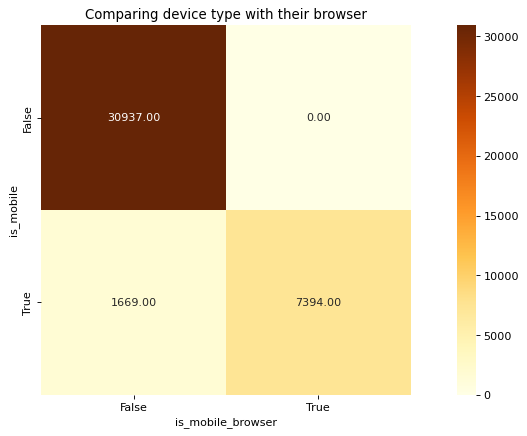

In [29]:
contingency_table = pd.crosstab(df['is_mobile'], df['is_mobile_browser'])
heatmap_from_contingency(contingency_table, "Comparing device type with their browser")

In [30]:
# this is done here because this change would affect the results of the cell checking for browsers linked to mobile
# the goal of the previous cell is to see if there are any non-mobile browsers
df['browser'] = df['browser'].apply(get_browser_family)
df.head(3)

,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_is_private,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,device,is_mobile,is_mobile_browser
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,False,False,CN,GB,NaN,25310.0,IE,Windows,None Other,False,False
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,False,False,FR,US,12322.0,20115.0,IE,Windows,None Other,False,False
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,False,False,US,US,701.0,NaN,IE,Windows,None Other,False,False


### Categorical Columns

In [31]:
get_categorical_vals(df, 15)

Skips booleans and numerics
Showing columns where the column unique value count is <= 15


,column,unique_values,count,notes
0,protocol,['ICMP' 'UDP' 'TCP'],3,
1,packet_type,['Data' 'Control'],2,
2,traffic_type,['HTTP' 'DNS' 'FTP'],3,
3,malware_indicators,['IoC Detected' nan],1,Possible boolean?
4,alerts_and_warnings,[nan 'Alert Triggered'],1,Possible boolean?
5,attack_type,['Malware' 'DDoS' 'Intrusion'],3,
6,attack_signature,['Known Pattern B' 'Known Pattern A'],2,
7,action_taken,['Logged' 'Blocked' 'Ignored'],3,
8,severity_level,['Low' 'Medium' 'High'],3,
9,network_segment,['Segment A' 'Segment B' 'Segment C'],3,


From the data generated above, we can see that some columns have few unique values. These values can indicate categories and therefore, they can be onehot encoded making it easier for the algorithms to understand.
Both ordinal and nominal encoding should be considered.

Possible fields for ordinal encoding: severity_level, action_taken?

In addition that that, there are columns that contain only 1 unique value; usually the single value and others are populated by null values. Those columns can be possibly used as booleans. proxy_information is another good contender for a boolean since we won't need the exact values but rather if a proxy was detected.

In [32]:
df['has_proxy'] = np.where(df['proxy_information'].notnull(),True,False)
df['has_malware_indicator'] = np.where(df['malware_indicators'].notnull(),True,False)
df['has_alerts_and_warnings'] = np.where(df['alerts_and_warnings'].notnull(),True,False)
df['has_firewall_log'] = np.where(df['firewall_logs'].notnull(),True,False)
df['has_ids_ips_alert'] = np.where(df['ids_and_ips_alerts'].notnull(),True,False)

show_nulls(df)
df.head(3)

,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_is_private,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,device,is_mobile,is_mobile_browser,has_proxy,has_malware_indicator,has_alerts_and_warnings,has_firewall_log,has_ids_ips_alert
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,False,False,CN,GB,NaN,25310.0,IE,Windows,None Other,False,False,True,True,False,True,False
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,False,False,FR,US,12322.0,20115.0,IE,Windows,None Other,False,False,False,True,False,True,False
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,False,False,US,US,701.0,NaN,IE,Windows,None Other,False,False,True,True,True,True,True


We can see that 4 out of the 5 new bools are related to alerts so a new column can be created to concat them - if at least 1 is true, then the new column, has_system_alert, will be true.
Additionally, we can get an count of all alerts into a new column, alert_count.

In [33]:
def has_system_alert(row):
    """True if any of the alert fields are true."""
    return True if row['has_malware_indicator'] or row['has_alerts_and_warnings'] or row['has_firewall_log'] or row['has_ids_ips_alert'] else False

def count_alerts(row):
    count = 0

    if row['has_malware_indicator']:
        count+=1
    if row['has_alerts_and_warnings']:
        count+=1
    if row['has_firewall_log']:
        count+=1
    if row['has_ids_ips_alert']:
        count+=1
        
    return count
    
df['has_system_alert'] = df.apply(has_system_alert, axis=1)
df['alert_count'] = df.apply(count_alerts, axis=1)

print(df['has_system_alert'].value_counts())
df.head(3)

has_system_alert
True     37490
False     2510
Name: count, dtype: int64


,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,month,quarter,year,source_ip_address_is_private,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,device,is_mobile,is_mobile_browser,has_proxy,has_malware_indicator,has_alerts_and_warnings,has_firewall_log,has_ids_ips_alert,has_system_alert,alert_count
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,5,2,2023,False,False,CN,GB,NaN,25310.0,IE,Windows,None Other,False,False,True,True,False,True,False,True,2
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,8,3,2020,False,False,FR,US,12322.0,20115.0,IE,Windows,None Other,False,False,False,True,False,True,False,True,2
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,11,4,2022,False,False,US,US,701.0,NaN,IE,Windows,None Other,False,False,True,True,True,True,True,True,4


Well... based on the value_counts on has_system_alert, it looks useless, lol.

### Networking Stuff

The columns: protocol, packet_length, packet_type, traffic_type, payload_data can be combined somehow to create one or a few new columns.

In [34]:
for loc in ['source', 'destination']:
    df[f'{loc}_port_bin'] = df[f'{loc}_port'].apply(
        lambda value: "registered" if 1024 <= value <= 49151 else "dynamic"
    )

df['packet_length_bin'] = df['packet_length'].apply(
    lambda x: "Small" if x <= 256 else
    "Medium" if x <= 512 else
    "Large" if x <= 1024 else
    "Very Large"
)

df['packet_length_bin'].value_counts()

packet_length_bin
Large         14168
Very Large    13282
Medium         7143
Small          5407
Name: count, dtype: int64

In [35]:
def is_popular_port(port):
    """Uses the external dataset (list) to get popular ports."""
    return True if port in l_ports else False

df['is_popular_source_port'] = df['source_port'].apply(is_popular_port)
df['is_popular_destination_port'] = df['destination_port'].apply(is_popular_port)

# protocol_uses_ports created because it is understood that ICMP does not use ports
df['protocol_uses_ports'] = df['protocol'].apply(lambda x : False if x == 'ICMP' else True)

print(df['is_popular_source_port'].value_counts())
print(df['is_popular_destination_port'].value_counts())
print(df['protocol_uses_ports'].value_counts())

is_popular_source_port
False    35419
True      4581
Name: count, dtype: int64
is_popular_destination_port
False    35485
True      4515
Name: count, dtype: int64
protocol_uses_ports
True     26571
False    13429
Name: count, dtype: int64


### Payload Data

The data could contain signs of an attack. Looks like auto-generated latin text.

In [36]:
df['payload_data'].tolist()[10000:10010]

['Eos eligendi occaecati impedit reprehenderit. Mollitia fugit ipsa a. Pariatur reprehenderit impedit quae cum. Amet nihil doloremque.',
 'Ipsa nam sequi ducimus nam fugit. Harum enim veniam.\nIste exercitationem natus temporibus inventore inventore ipsam. Nesciunt temporibus eaque ad odio nihil. Nihil aliquid et blanditiis.',
 'Deleniti quidem tenetur voluptates placeat corporis consectetur. Inventore illo sunt rem ipsam numquam.\nVoluptatibus ad facilis voluptas aperiam a quae. Laboriosam et beatae necessitatibus iste.',
 'Libero illo cupiditate sit. Ipsam recusandae dolores at deserunt.\nPraesentium sed sunt nihil. Veniam sint eum quisquam nesciunt deserunt officia.',
 'Nisi consectetur impedit accusamus aperiam. Quibusdam ea quas incidunt.\nDeleniti quidem suscipit cumque quae. Quidem eligendi natus est similique. Occaecati optio eum rem et deleniti.',
 'Asperiores dolorem nisi. Eligendi aperiam minus laboriosam.\nAliquam esse numquam architecto saepe in.\nProvident accusantium qua

### ASN & Countries

There is missing data in the countries and asn columns. Investigate.

In [37]:
show_nulls(df)

,0
malware_indicators,20000
alerts_and_warnings,20067
proxy_information,19851
firewall_logs,19961
ids_and_ips_alerts,20050
source_country,2
destination_country,7
source_asn_id,6604
destination_asn_id,6643


Since less than 10 countries are empty and about 15% ASN is empty, we can fill them with the modal value just to ensure the columns are filled for future tests.

In [38]:
df['source_country'].fillna(df['source_country'].mode()[0], inplace=True)
df['destination_country'].fillna(df['destination_country'].mode()[0], inplace=True)
df['source_asn_id'].fillna(df['source_asn_id'].mode()[0], inplace=True)
df['destination_asn_id'].fillna(df['destination_asn_id'].mode()[0], inplace=True)
show_nulls(df)

,0
malware_indicators,20000
alerts_and_warnings,20067
proxy_information,19851
firewall_logs,19961
ids_and_ips_alerts,20050


In [39]:
# the ASN IDs are supposed to be int rather than float
df['source_asn_id'] = df['source_asn_id'].astype(np.int64)
df['destination_asn_id'] = df['destination_asn_id'].astype(np.int64)
print(df.source_asn_id.dtype)
print(df.destination_asn_id.dtype)

int64
int64


'geo-location_data' has 8723 unique values - too many unique values. We already have location based on IP Address so we won't use that column.

'year' column has too little information for it to be used. The reasoning is because the year is supposed to show a continuous progression in time and our dataset only covers a time period of 2020-2023.

### Drop Columns (Part 2)

The columns being dropped are based on the above sections of data transformation, like binning/bucketing, and finding useless columns.

In [40]:
columns_to_drop = [
    'malware_indicators', 'alerts_and_warnings', 'proxy_information', 'firewall_logs', 'ids_and_ips_alerts',
    'source_port', 'destination_port', 'packet_length', 'payload_data', 'geo-location_data', 'year'
]
df.drop(columns_to_drop, axis=1, inplace=True)

## More Analysis

#### Class Distribution (for target)

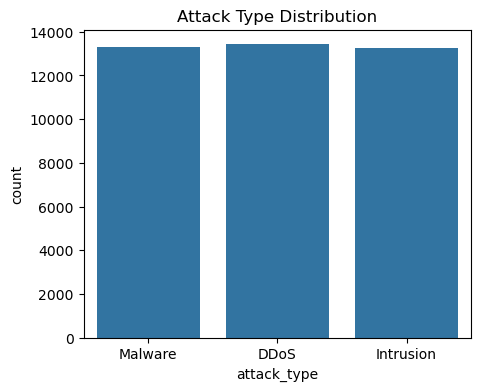

In [41]:
plt.figure(figsize=(5,4))
sns.countplot(x=df['attack_type'])
plt.title('Attack Type Distribution')
plt.show()

The graph above shows that the target variables are uniform.

### Some Preprocessing - Encoding - Feature Handling

Since there are different feature types, they have to be treated differently by the model and so they need to be encoded differently. We merge them using a ColumnTransformer. See documentation below:
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline_column_transformer.html

A class was developed to easily handle features during feature selection and model training.

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler
import re

class FeatureHandler():
    """Handle the different characteristics of features."""

    def __init__(self):
        self.X = df.drop(columns=['attack_type'])
        self.y = df['attack_type'].to_numpy()

        # automatically assigns columns based on dtypes
        features_numeric = self.X.select_dtypes(include=['int32', 'int64', 'float64']).columns.values
        features_object = self.X.select_dtypes(include='object').columns.values
        
        # hand picked columns to be encoded differently from its dtype siblings
        features_specific = {
            'ordinal': ['severity_level', 'packet_length_bin'],
            'mean': ['source_country', 'destination_country', 'source_asn_id', 'destination_asn_id'],
        }

        self.features = {
            'onehot': [x for x in features_object if x not in (features_specific['ordinal'] + features_specific['mean'])],
            'ordinal': features_specific['ordinal'],
            'mean': features_specific['mean'],
            'bool': list(self.X.select_dtypes(include='bool').columns.values),
            'numeric': [x for x in features_numeric if x not in (features_specific['ordinal'] + features_specific['mean'])]
        }

    def filter(self, selected_features):
        """
        Removes all features that are not selected from this object's X property.

        Args:
            selected_features: [str]
        """
        features = {}
        # loops through all values within all types to directly compare with
        # the selected features
        for f_type, values in self.features.items():
            features[f_type] = []
            for v in values:
                if v in selected_features:
                    features[f_type].append(v)

        self.features = features
        self.X = self.X[selected_features]

    @property
    def feature_count(self):
        """
        Base feature count. Counts done on object's features property; not on the ColumnTransformer.

        Returns:
            int
        """
        count = 0
        for f_types in self.features:
            count += len(self.features[f_types])
        return count

    @property
    def preprocessor(self):
        """
        ColumnTransformer - attaches columns (features) to their respective encoder.
        """

        ohe = OneHotEncoder(sparse_output=False, handle_unknown='error')
        oe_sl = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
        oe_pl = OrdinalEncoder(categories=[['Small', 'Medium', 'Large', 'Very Large']])
        te = TargetEncoder(target_type='multiclass', smooth='auto', cv=5)
        sc = StandardScaler()

        transformers = []
        if self.features['onehot']:
            transformers.append(('onehot', ohe, self.features['onehot']))
        if 'severity_level' in self.features['ordinal']:
            transformers.append(('ordinal-sl', oe_sl, ['severity_level']))
        if 'packet_length_bin' in self.features['ordinal']:
            transformers.append(('ordinal-pl', oe_pl, ['packet_length_bin']))
        if self.features['mean']:
            transformers.append(('target', te, self.features['mean']))
        if self.features['bool']:
            transformers.append(('bool_passthrough', 'passthrough', self.features['bool']))
        if self.features['numeric']:
            transformers.append(('std_scaler', sc, self.features['numeric']))
    
        return ColumnTransformer(transformers)

    def group_transformed_features(self, features_t):
        """
        Takes transformed/encoded features and transforms them back to their base features.

        Args:
            features_t: [str]
                list of transformed/encoded feature names

        Returns:
            [str]
                list of base features; just the names
        """
        features = []
        for feature_t in features_t:
            # the transformers would separate their identifier from the feature
            # with double underscores
            split = feature_t.split('__', 1)
            preprocessor = split[0]
            feature_ = split[1]

            # the target/mean encoder would add a suffix to differentiate each
            # target cateogry. since the target is transformed too, they are
            # single digits
            if preprocessor == 'target':
                feature_ = feature_.rsplit('_', 1)[0]

            if preprocessor == 'onehot':
                for f in self.features['onehot']:
                    pattern = r'(^|_)' + re.escape(f) + r'(_|$)'
                    if re.search(pattern, feature_):
                        feature_ = f
                        break

            # skip if encoding does not split column - has default feature name
            if feature_ in features:
                continue
            features.append(feature_)
        return features

    def add_feature_by_concat(self, feature_list, encoding_type):
        """
        Creates new feature by concatentation.

        Args:
            feature_list: [str]
            encoding_type: str
                one of the groups from self.features
        """
        delimiter = '|'
        if encoding_type in self.features.keys():
            new_col_name = delimiter.join(feature_list)
            self.X[new_col_name] = self.X[feature_list].astype(str).agg(delimiter.join, axis=1)
            self.features[encoding_type].append(new_col_name)
        else:
            raise Exception("Encoding type not supported")

In [43]:
fh = FeatureHandler()

fh.add_feature_by_concat(['protocol', 'packet_type'], 'onehot')
fh.add_feature_by_concat(['protocol', 'traffic_type'], 'onehot')
fh.add_feature_by_concat(['protocol', 'protocol_uses_ports'], 'mean')

#Ports with something else
fh.add_feature_by_concat(['source_port_bin', 'protocol_uses_ports'], 'onehot')
fh.add_feature_by_concat(['destination_port_bin', 'protocol_uses_ports'], 'onehot')
fh.add_feature_by_concat(['source_port_bin', 'protocol_uses_ports', 'action_taken'], 'mean')
fh.add_feature_by_concat(['destination_port_bin', 'protocol_uses_ports', 'action_taken'], 'mean')
fh.add_feature_by_concat(['source_port_bin', 'protocol_uses_ports', 'traffic_type'], 'mean')
fh.add_feature_by_concat(['destination_port_bin', 'protocol_uses_ports', 'traffic_type'], 'mean')

#Packet Lenght with something else
fh.add_feature_by_concat(['packet_length_bin', 'traffic_type'], 'mean')
fh.add_feature_by_concat(['packet_length_bin', 'packet_type'], 'onehot')
fh.add_feature_by_concat(['packet_length_bin', 'protocol'], 'mean')
fh.add_feature_by_concat(['packet_length_bin', 'log_source'], 'onehot')

#Packet Type with something else
fh.add_feature_by_concat(['packet_type', 'protocol'], 'onehot')
fh.add_feature_by_concat(['packet_type', 'log_source'], 'onehot')
fh.add_feature_by_concat(['packet_type', 'traffic_type', 'log_source'], 'mean')

#Coutries
fh.add_feature_by_concat(['source_country', 'destination_country'], 'mean')
fh.add_feature_by_concat(['source_country', 'destination_country', 'has_proxy'], 'mean')

#protocol_uses_ports
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'source_port_bin', 'protocol_uses_ports', 'action_taken'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'destination_port_bin', 'protocol_uses_ports', 'action_taken'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'source_port_bin', 'protocol_uses_ports', 'action_taken', 'has_ids_ips_alert'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'destination_port_bin', 'protocol_uses_ports', 'action_taken', 'has_ids_ips_alert'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'source_port_bin', 'protocol_uses_ports', 'action_taken', 'has_ids_ips_alert', 'packet_length_bin'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'destination_port_bin', 'protocol_uses_ports', 'action_taken', 'has_ids_ips_alert', 'packet_length_bin'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'source_port_bin', 'protocol_uses_ports', 'action_taken', 'has_alerts_and_warnings'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'destination_port_bin', 'protocol_uses_ports', 'action_taken', 'has_alerts_and_warnings'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'source_port_bin', 'protocol_uses_ports', 'action_taken', 'has_alerts_and_warnings', 'has_firewall_log'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'destination_port_bin', 'protocol_uses_ports', 'action_taken', 'has_alerts_and_warnings', 'has_firewall_log'
], 'mean')

fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'source_port_bin', 'protocol_uses_ports', 'action_taken',
    'has_alerts_and_warnings', 'has_firewall_log', 'has_malware_indicator'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'destination_port_bin', 'protocol_uses_ports', 'action_taken',
    'has_alerts_and_warnings', 'has_firewall_log', 'has_malware_indicator'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'source_port_bin', 'protocol_uses_ports', 'action_taken',
    'has_alerts_and_warnings', 'has_firewall_log', 'has_malware_indicator', 'action_taken'
], 'mean')
fh.add_feature_by_concat([
    'protocol', 'traffic_type', 'destination_port_bin', 'protocol_uses_ports', 'action_taken',
    'has_alerts_and_warnings', 'has_firewall_log', 'has_malware_indicator', 'action_taken'
], 'mean')

#trf_tp_protocol
fh.add_feature_by_concat(['protocol', 'traffic_type', 'packet_type'], 'mean')
fh.add_feature_by_concat(['protocol', 'traffic_type', 'severity_level'], 'mean')

# fh.features
fh.X.head(3)

,protocol,packet_type,traffic_type,anomaly_scores,attack_signature,action_taken,severity_level,network_segment,log_source,hour,day_of_week,month,quarter,source_ip_address_is_private,destination_ip_address_is_private,source_country,destination_country,source_asn_id,destination_asn_id,browser,os,device,is_mobile,is_mobile_browser,has_proxy,has_malware_indicator,has_alerts_and_warnings,has_firewall_log,has_ids_ips_alert,has_system_alert,alert_count,source_port_bin,destination_port_bin,packet_length_bin,is_popular_source_port,is_popular_destination_port,protocol_uses_ports,protocol|packet_type,protocol|traffic_type,protocol|protocol_uses_ports,source_port_bin|protocol_uses_ports,destination_port_bin|protocol_uses_ports,source_port_bin|protocol_uses_ports|action_taken,destination_port_bin|protocol_uses_ports|action_taken,source_port_bin|protocol_uses_ports|traffic_type,destination_port_bin|protocol_uses_ports|traffic_type,packet_length_bin|traffic_type,packet_length_bin|packet_type,packet_length_bin|protocol,packet_length_bin|log_source,packet_type|protocol,packet_type|log_source,packet_type|traffic_type|log_source,source_country|destination_country,source_country|destination_country|has_proxy,protocol|traffic_type|source_port_bin|protocol_uses_ports|action_taken,protocol|traffic_type|destination_port_bin|protocol_uses_ports|action_taken,protocol|traffic_type|source_port_bin|protocol_uses_ports|action_taken|has_ids_ips_alert,protocol|traffic_type|destination_port_bin|protocol_uses_ports|action_taken|has_ids_ips_alert,protocol|traffic_type|source_port_bin|protocol_uses_ports|action_taken|has_ids_ips_alert|packet_length_bin,protocol|traffic_type|destination_port_bin|protocol_uses_ports|action_taken|has_ids_ips_alert|packet_length_bin,protocol|traffic_type|source_port_bin|protocol_uses_ports|action_taken|has_alerts_and_warnings,protocol|traffic_type|destination_port_bin|protocol_uses_ports|action_taken|has_alerts_and_warnings,protocol|traffic_type|source_port_bin|protocol_uses_ports|action_taken|has_alerts_and_warnings|has_firewall_log,protocol|traffic_type|destination_port_bin|protocol_uses_ports|action_taken|has_alerts_and_warnings|has_firewall_log,protocol|traffic_type|source_port_bin|protocol_uses_ports|action_taken|has_alerts_and_warnings|has_firewall_log|has_malware_indicator,protocol|traffic_type|destination_port_bin|protocol_uses_ports|action_taken|has_alerts_and_warnings|has_firewall_log|has_malware_indicator,protocol|traffic_type|source_port_bin|protocol_uses_ports|action_taken|has_alerts_and_warnings|has_firewall_log|has_malware_indicator|action_taken,protocol|traffic_type|destination_port_bin|protocol_uses_ports|action_taken|has_alerts_and_warnings|has_firewall_log|has_malware_indicator|action_taken,protocol|traffic_type|packet_type,protocol|traffic_type|severity_level
0,ICMP,Data,HTTP,28.67,Known Pattern B,Logged,Low,Segment A,Server,6,1,5,2,False,False,CN,GB,749,25310,IE,Windows,None Other,False,False,True,True,False,True,False,True,2,registered,registered,Medium,False,False,False,ICMP|Data,ICMP|HTTP,ICMP|False,registered|False,registered|False,registered|False|Logged,registered|False|Logged,registered|False|HTTP,registered|False|HTTP,Medium|HTTP,Medium|Data,Medium|ICMP,Medium|Server,Data|ICMP,Data|Server,Data|HTTP|Server,CN|GB,CN|GB|True,ICMP|HTTP|registered|False|Logged,ICMP|HTTP|registered|False|Logged,ICMP|HTTP|registered|False|Logged|False,ICMP|HTTP|registered|False|Logged|False,ICMP|HTTP|registered|False|Logged|False|Medium,ICMP|HTTP|registered|False|Logged|False|Medium,ICMP|HTTP|registered|False|Logged|False,ICMP|HTTP|registered|False|Logged|False,ICMP|HTTP|registered|False|Logged|False|True,ICMP|HTTP|registered|False|Logged|False|True,ICMP|HTTP|registered|False|Logged|False|True|True,ICMP|HTTP|registered|False|Logged|False|True|True,ICMP|HTTP|registered|False|Logged|False|True|T...,ICMP|HTTP|registered|False|Logged|False|True|T...,ICMP|HTTP|Data,ICMP|HTTP|Low
1,ICMP,Data,HTTP,51.50,Known Pattern A,Blocked,Low,Seg

In [44]:
fh.X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 71 columns):
 #   Column                                                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                                                   --------------  -----  
 0   protocol                                                                                                                                                 40000 non-null  object 
 1   packet_type                                                                                                                                              40000 non-null  object 
 2   traffic_type                                                                                                                                             40000

In [45]:
show_nulls(fh.X)

,0


In [46]:
show_dtypes(fh.X)

,0
0,object
1,float64
2,int32
3,bool
4,int64


In [47]:
get_col_unique_vals(fh.X, gte=10)

,0
anomaly_scores,9826
hour,24
month,12
source_country,188
destination_country,175
source_asn_id,4873
destination_asn_id,4803
source_port_bin|protocol_uses_ports|action_taken,12
destination_port_bin|protocol_uses_ports|action_taken,12
source_port_bin|protocol_uses_ports|traffic_type,12


In [48]:
get_categorical_vals(fh.X, 10)

Skips booleans and numerics
Showing columns where the column unique value count is <= 10


,column,unique_values,count,notes
0,protocol,['ICMP' 'UDP' 'TCP'],3,
1,packet_type,['Data' 'Control'],2,
2,traffic_type,['HTTP' 'DNS' 'FTP'],3,
3,attack_signature,['Known Pattern B' 'Known Pattern A'],2,
4,action_taken,['Logged' 'Blocked' 'Ignored'],3,
5,severity_level,['Low' 'Medium' 'High'],3,
6,network_segment,['Segment A' 'Segment B' 'Segment C'],3,
7,log_source,['Server' 'Firewall'],2,
8,browser,['IE' 'Firefox' 'Opera' 'Chrome' 'Safari'],5,
9,os,['Windows' 'Mac OS X' 'Linux' 'iOS' 'Android'],5,


## Feature Selection

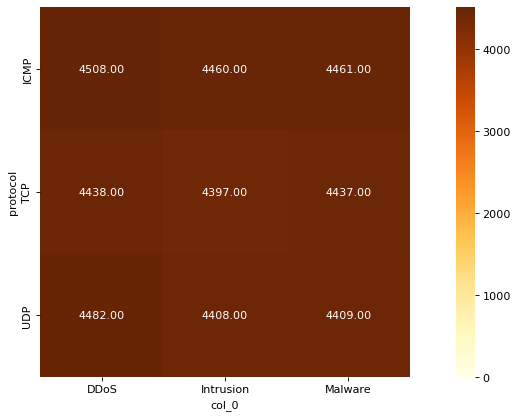

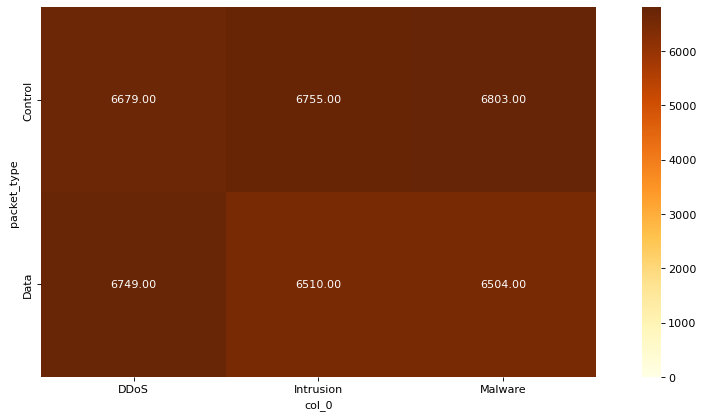

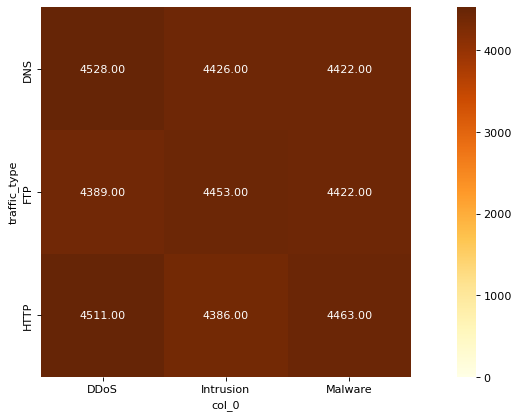

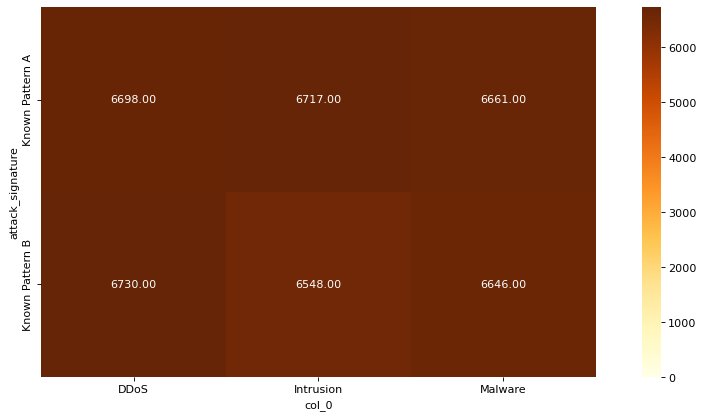

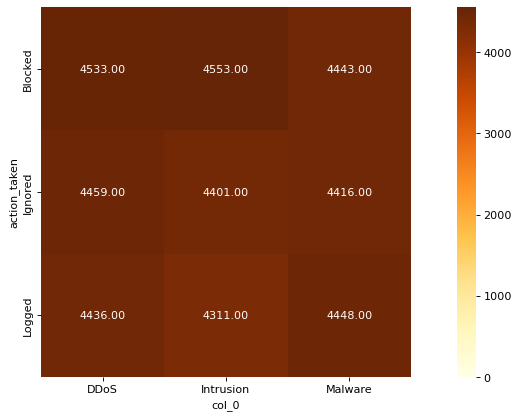

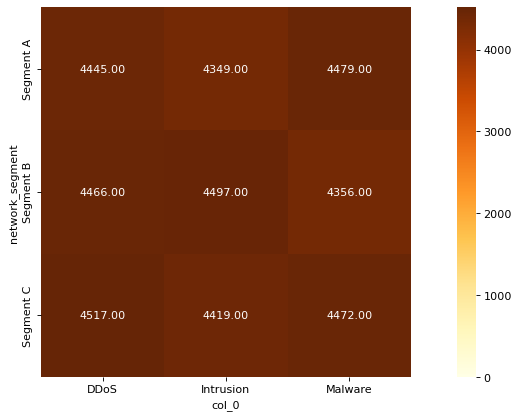

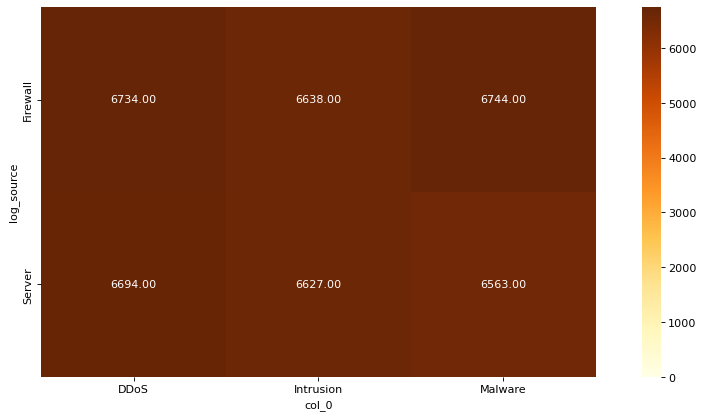

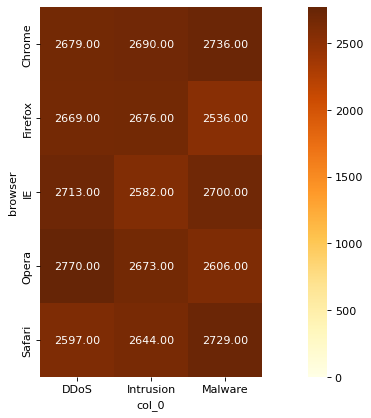

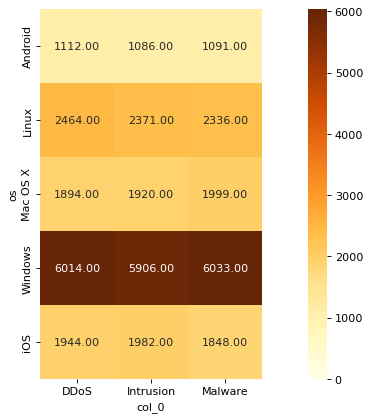

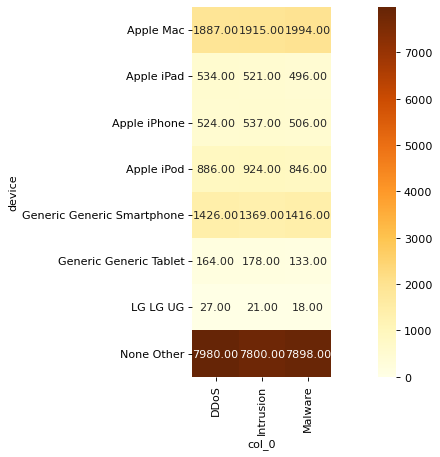

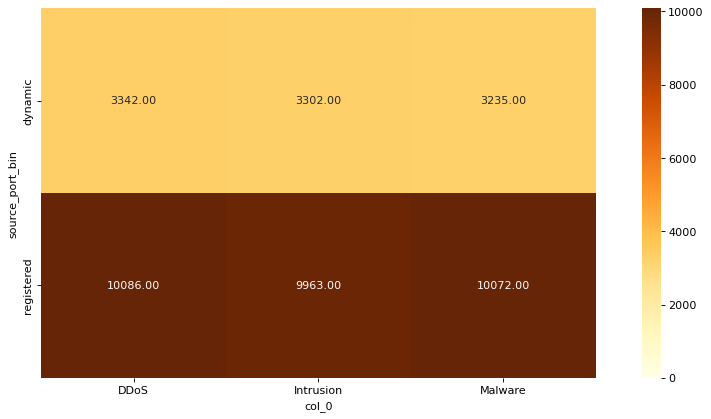

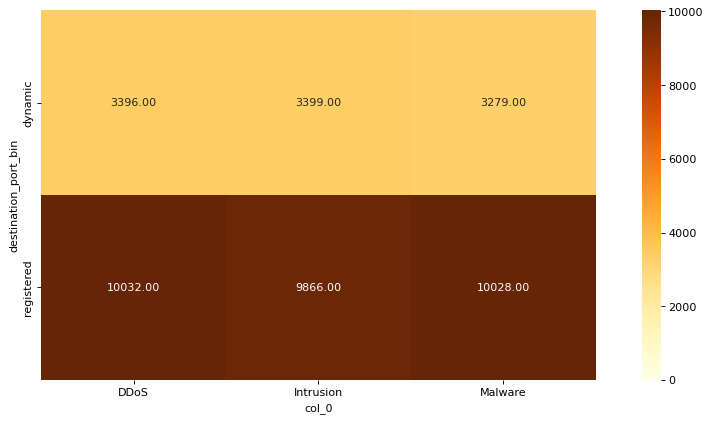

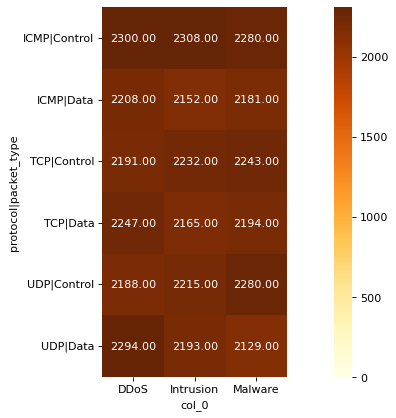

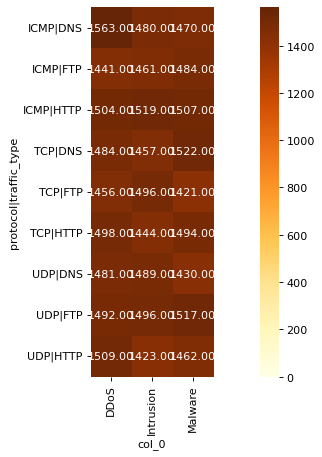

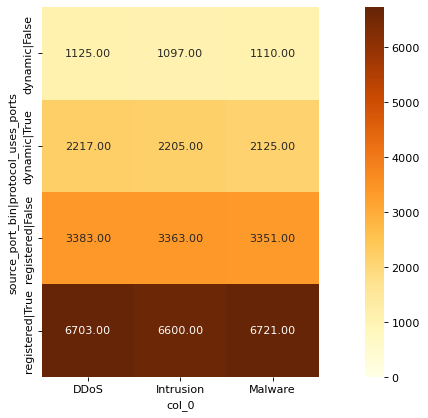

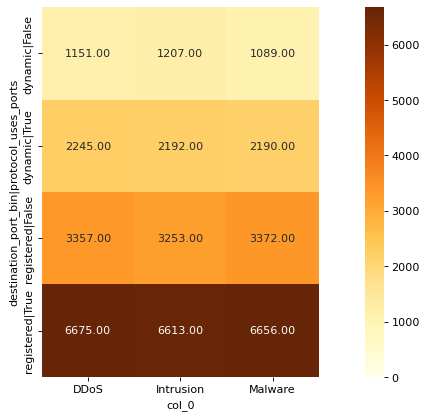

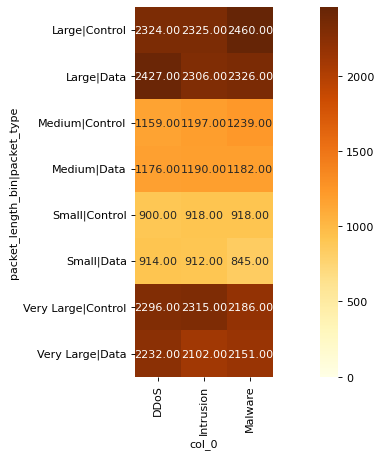

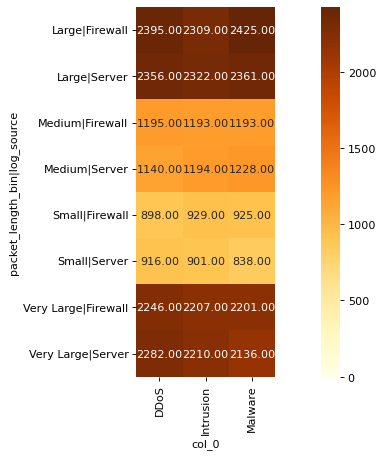

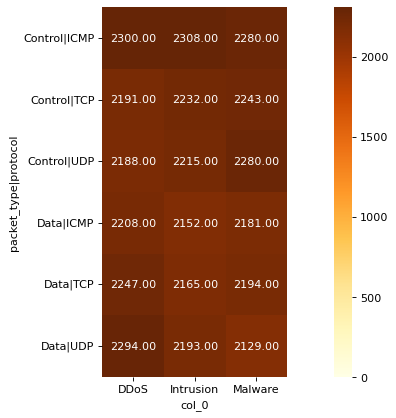

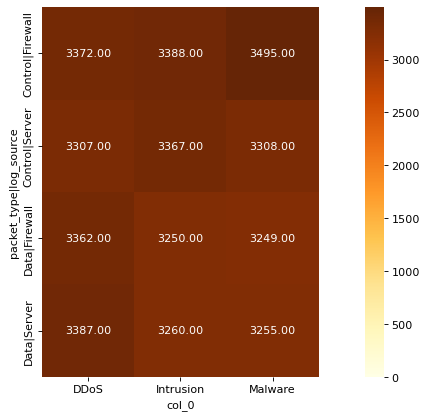

In [49]:
for feature in fh.features['onehot']:
    contingency_table = pd.crosstab(fh.X[feature], fh.y)
    heatmap_from_contingency(contingency_table)

### Chi^2 Test (Visual)

We can check categorical using chi squared. Future graphs can be generated using anova.

"The Chi-square test is a statistical test that is used to determine whether there is a significant difference between the observed frequency of a categorical variable and the expected frequency based on the assumption of independence. It can be used to select the best categorical features for a classification model."
From: https://datascience.stackexchange.com/questions/117287/are-chi-square-and-anova-f-classif-to-select-best-features

"The Chi-Square test determines whether there is a significant association between two categorical variables. It helps in hypothesis testing to check whether observed frequencies differ from expected ones."
"If the p-value is less than the significance level (typically 0.05), reject the null hypothesis, indicating a significant relationship between the variables.
If the p-value is greater than 0.05, fail to reject the null hypothesis, meaning no significant relationship was found."
From: https://www.simplilearn.com/tutorials/statistics-tutorial/chi-square-test

In [50]:
from scipy.stats import chi2_contingency

def chi_square_test(feature):
    contingency_table = pd.crosstab(fh.X[feature], fh.y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return feature, chi2, p

def plot_chi_square(chi_square_df):
    fig, axs = plt.subplots(1,2)
    chi2_df = chi_square_df.sort_values(by='chi2', ascending=False)
    pv_df = chi_square_df.sort_values(by='p', ascending=True) 
    chi2_df.plot.bar(x='feature', y='chi2', figsize=(13,4), ax=axs[0])
    pv_df.plot.bar(x='feature', y='p', ax=axs[1])

,feature,chi2,p
1,packet_type,5.992260,0.049980
7,browser,16.683922,0.033574
3,is_mobile_browser,7.725519,0.021010


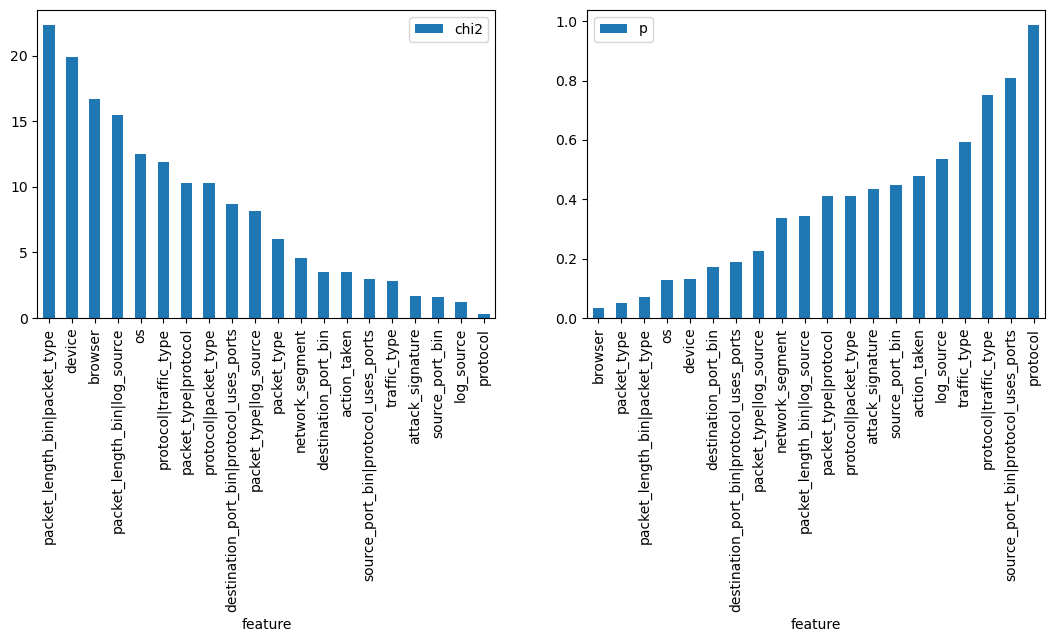

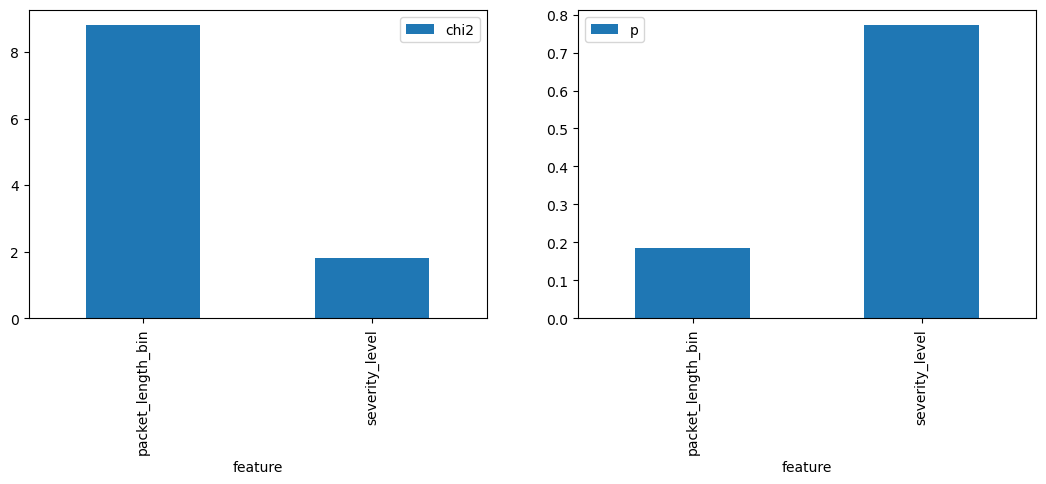

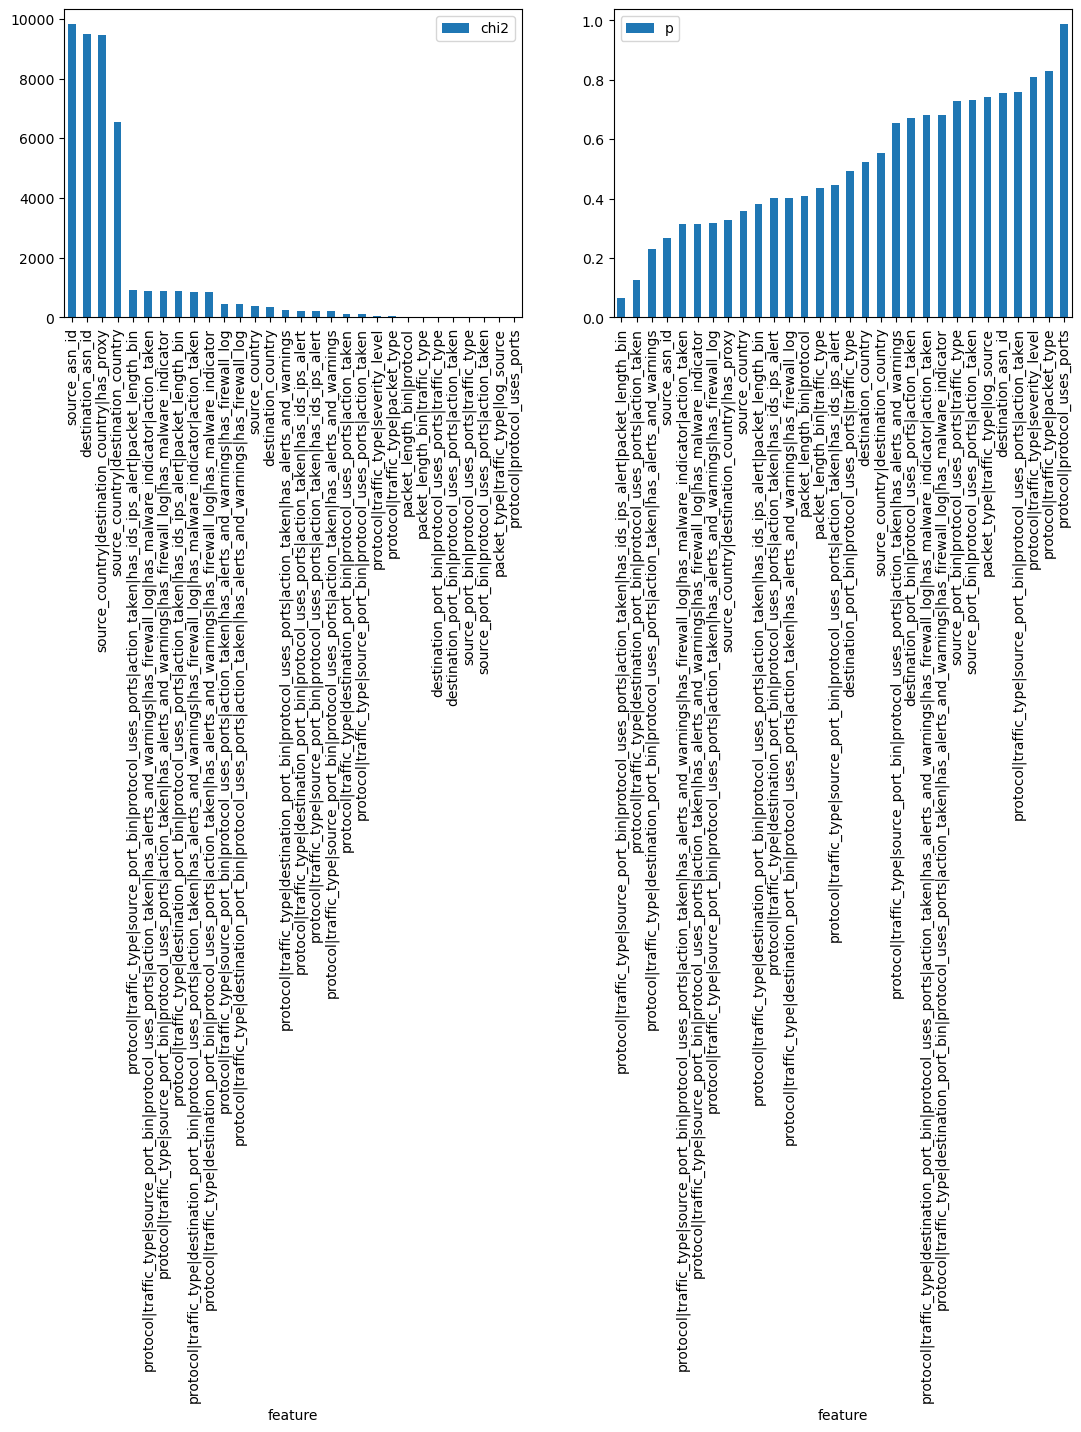

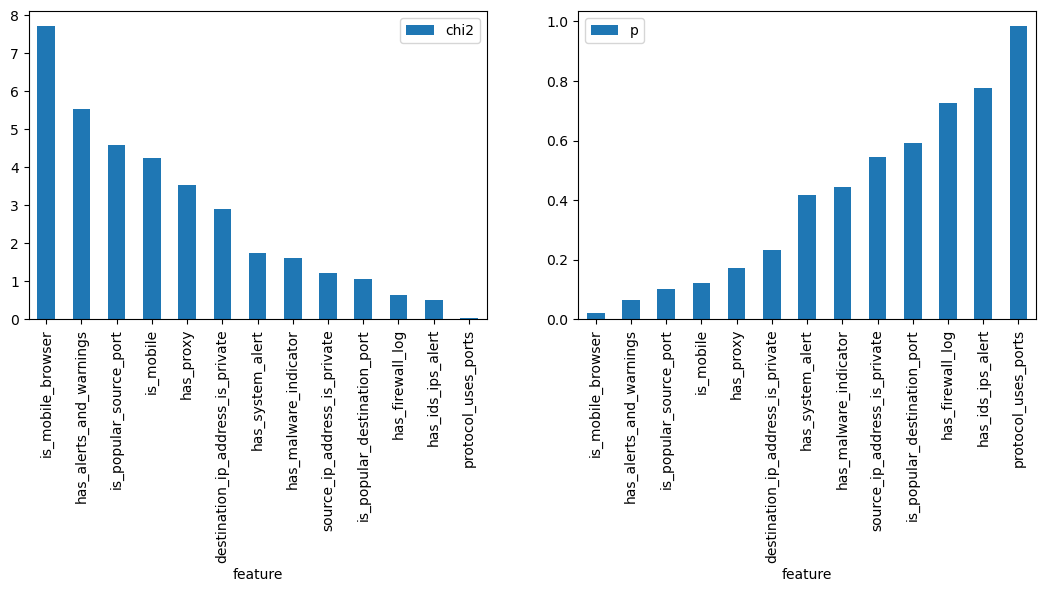

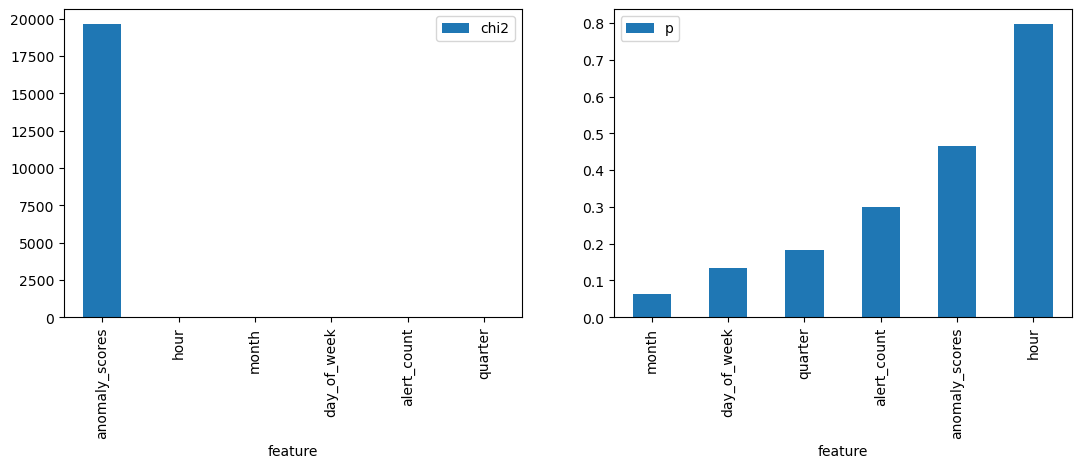

In [51]:
appended = []

for features in fh.features.values():
    chi_square_results = [chi_square_test(feature) for feature in features]
    chi_square_df = pd.DataFrame(chi_square_results, columns=['feature', 'chi2', 'p'])
    appended.append(chi_square_df)
    plot_chi_square(chi_square_df)

chi_square_df_full = pd.concat(appended)
# features with p-values < 0.05 are statistically significant
chi_square_df_full[chi_square_df_full['p'] < 0.05]

## Feature Selection Model Setup

This section includes initializations and definitions for wrapper functions and models. Parameter settings here too.

Things to remember when dealing with sklearn:

- make_pipeline() automatically names the pipeline steps by making the estimator name lowercase. If you want to see the parameters of the pipeline, use get_params() on the pipeline.
- when in a pipeline, the methods are run on all estimators in sequence and the output result will be from the last estimator. This should be remembered especially when using more than one estimators in sequence. For example, the SelectKBest estimator transforms the data that is used later within a model but in this case we don't have to do that step manually - the pipepine will take care of that.

In [52]:
from sklearn.base import BaseEstimator, ClassifierMixin

class PipelineTargetTransformerWrapper(BaseEstimator, ClassifierMixin):
    """
    Wraps transformers making for easier management and recycling code.
    All transformations handles elegantly within the wrapper, even the target variable.

    Builds upon sklearn's consistent structure/api. Their functions similarly across all
    models. For example: fit, predict, score.
    """
    def __init__(self, pipeline):
        self.pipeline = pipeline
        self.target_transformer = LabelEncoder()
        self.features_data = {}
    
    def fit(self, X_train, y_train):
        y_transformed = self.target_transformer.fit_transform(y_train)
        self.pipeline.fit(X_train, y_transformed)
        self.classes_ = self.target_transformer.classes_
        return self
    
    def predict(self, X_test):
        y = self.pipeline.predict(X_test)
        return self.target_transformer.inverse_transform(y)

    def score(self, X_test, y_test):
        y_transformed = self.target_transformer.fit_transform(y_test)
        return self.pipeline.score(X_test, y_transformed) * 100

    def set_features_data(self, X_all):
        """
        Attaches feature data to the wrapper so that it can be saved with
        the model. This would make accessing feature information easier
        in external environments.

        Args:
            X_all: df.DataFrame
                DataFrame holding all features with their data.
        """
        for col in X_all:
            if X_all[col].dtype == 'object':
                self.features_data[col] = {
                    'type': 'categorical',
                    'values': X_all[col].unique().tolist()
                }
            elif X_all[col].dtype in ['float64', 'int32', 'int64']:
                self.features_data[col] = {
                    'type': 'numerical',
                    'values': {
                        'min': X_all[col].min(),
                        'max': X_all[col].max()
                    }
                }
            elif X_all[col].dtype == 'bool':
                self.features_data[col] = {
                    'type': 'bool',
                    'values': [True, False]
                }
            else:
                raise Exception("No values found.")

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# splits data to be used across all models during evaluation
X_train, X_test, y_train, y_test = train_test_split(fh.X, fh.y, test_size=0.2, shuffle=True, stratify=fh.y, random_state=42)

# initialize models with mostly base hyperparameters to be used as base points
# lr = LinearRegression()
logr = LogisticRegression(solver='newton-cg', random_state=42, n_jobs=-1)
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
gbc = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42, n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
svc = SVC(kernel='linear', random_state=42)
# SVC with rbf kernel is giving an error
# It should be noted that SVC requires StandardScaling throughout the dataset
# Currently, the dataset does not apply StandardScaling
# svc = SVC(kernel='rbf', random_state=42)

fh.preprocessor

ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse_output=False),
                                 ['protocol', 'packet_type', 'traffic_type',
                                  'attack_signature', 'action_taken',
                                  'network_segment', 'log_source', 'browser',
                                  'os', 'device', 'source_port_bin',
                                  'destination_port_bin',
                                  'protocol|packet_type',
                                  'protocol|traffic_type',
                                  'source_port_bin|protocol_uses_ports',
                                  'destination_port...
                                  'destination_ip_address_is_private',
                                  'is_mobile', 'is_mobile_browser', 'has_proxy',
                                  'has_malware_indicator',
                                  'has_alerts_and_warnings', 'has_firewall_log',
                                  'has_ids_ips_alert', 'has_system_alert',
                                  'is_popular_source_port',
                                  'is_popular_destination_port',
                                  'protocol_uses_ports']),
                                ('std_scaler', StandardScaler(),
                                 ['anomaly_scores', 'hour', 'day_of_week',
                                  'month', 'quarter', 'alert_count'])])

### Baselines

In [54]:
# Linear Regression - not fitted for classification

# plwr_base_lr = PipelineTargetTransformerWrapper(
#     make_pipeline(fh.preprocessor, lr)
# )
# plwr_base_lr.fit(X_train, y_train)
# plwr_base_lr_pred = plwr_base_lr.predict(X_test)
# plwr_base_lr.score(X_test, y_test)
# print(classification_report(y_test, plwr_base_lr_pred))

In [55]:
# Logistic Regression

plwr_base_logr = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, logr)
)
plwr_base_logr.fit(X_train, y_train)
plwr_base_logr_pred = plwr_base_logr.predict(X_test)
print(plwr_base_logr.score(X_test, y_test))
print(classification_report(y_test, plwr_base_logr_pred))

34.7375
              precision    recall  f1-score   support

        DDoS       0.35      0.36      0.35      2686
   Intrusion       0.34      0.30      0.32      2653
     Malware       0.35      0.39      0.37      2661

    accuracy                           0.35      8000
   macro avg       0.35      0.35      0.35      8000
weighted avg       0.35      0.35      0.35      8000



In [56]:
# Random Forest Classifier

plwr_base_rfc = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, rfc)
)
plwr_base_rfc.fit(X_train, y_train)
plwr_base_rfc_pred = plwr_base_rfc.predict(X_test)
print(plwr_base_rfc.score(X_test, y_test))
print(classification_report(y_test, plwr_base_rfc_pred))

33.375
              precision    recall  f1-score   support

        DDoS       0.34      0.36      0.35      2686
   Intrusion       0.33      0.32      0.32      2653
     Malware       0.33      0.32      0.33      2661

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



In [57]:
# Gradient Boosting Classifier

plwr_base_gbc = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, gbc)
)
plwr_base_gbc.fit(X_train, y_train)
plwr_base_gbc_pred = plwr_base_gbc.predict(X_test)
print(plwr_base_gbc.score(X_test, y_test))
print(classification_report(y_test, plwr_base_gbc_pred))

33.75
              precision    recall  f1-score   support

        DDoS       0.34      0.37      0.36      2686
   Intrusion       0.33      0.27      0.30      2653
     Malware       0.34      0.36      0.35      2661

    accuracy                           0.34      8000
   macro avg       0.34      0.34      0.34      8000
weighted avg       0.34      0.34      0.34      8000



In [58]:
# XGBoost

plwr_base_xgb = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, xgb)
)
plwr_base_xgb.fit(X_train, y_train)
plwr_base_xgb_pred = plwr_base_xgb.predict(X_test)
print(plwr_base_xgb.score(X_test, y_test))
print(classification_report(y_test, plwr_base_xgb_pred))

32.4375
              precision    recall  f1-score   support

        DDoS       0.33      0.34      0.33      2686
   Intrusion       0.32      0.31      0.32      2653
     Malware       0.32      0.32      0.32      2661

    accuracy                           0.32      8000
   macro avg       0.32      0.32      0.32      8000
weighted avg       0.32      0.32      0.32      8000



In [59]:
# KNN

plwr_base_knn = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, knn)
)
plwr_base_knn.fit(X_train, y_train)
plwr_base_knn_pred = plwr_base_knn.predict(X_test)
print(plwr_base_knn.score(X_test, y_test))
print(classification_report(y_test, plwr_base_knn_pred))

32.425
              precision    recall  f1-score   support

        DDoS       0.33      0.38      0.35      2686
   Intrusion       0.33      0.33      0.33      2653
     Malware       0.32      0.26      0.29      2661

    accuracy                           0.32      8000
   macro avg       0.32      0.32      0.32      8000
weighted avg       0.32      0.32      0.32      8000



In [60]:
# SVC

plwr_base_svc = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, svc)
)
plwr_base_svc.fit(X_train, y_train)
plwr_base_svc_pred = plwr_base_svc.predict(X_test)
print(plwr_base_svc.score(X_test, y_test))
print(classification_report(y_test, plwr_base_svc_pred))

33.9125
              precision    recall  f1-score   support

        DDoS       0.34      0.36      0.35      2686
   Intrusion       0.34      0.26      0.30      2653
     Malware       0.34      0.39      0.36      2661

    accuracy                           0.34      8000
   macro avg       0.34      0.34      0.34      8000
weighted avg       0.34      0.34      0.34      8000



### Feature Selection using Models

From this point on, logistic regression, random forest and xgboost will used as our model choices - they perfromed the best across the board. 

The Gradient Boost Classifier also performed good but it was too inefficient compared to the other choices, especially when compared to random forest. It usually performs around the same as random forest while taking much longer to run. Therefore, it was removed from further tests (even though it was tested there before).

#### SelectKBest with (chi2, mutual_info_classif, f_classif)

The f_classif (ANOVA f-test) performed better than chi2 across the board for our dataset. So from here on f_classif will be used.

The tests that follow use SelectKBest eith a single feature all the way up to using all features. A graph and some simple stats will generated to guage the amount of features that would get the best (or close to the best results). The goal is to find the lowest amount of features that gets a reasonably high score.

In [61]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

class SelectKBestRunner():
    """Helper to easily replicate SelectKBest across models"""
    
    # score_func options for this dataset: chi2, mutual_info_classif, f_classif (anova)
    def __init__(self, preprocessor, split_data, classifier, score_func):
        self.classifier = classifier
        self.score_func = score_func
        self.split_data = split_data
        self.preprocessor = preprocessor
        self.f1_score_list = []
        self.feature_count = 0
        
    def get_f1_score_list(self):
        feature_count = 1 # only to get it started
        k = 1
        
        while(k <= feature_count):
            pl_kbest = PipelineTargetTransformerWrapper(
                make_pipeline(self.preprocessor, SelectKBest(self.score_func, k=k), self.classifier)
            )
            pl_kbest.fit(split_data['X_train'], split_data['y_train'])
            pl_kbest_pred = pl_kbest.predict(split_data['X_test'])
            pl_kbest_f1_score = round(f1_score(split_data['y_test'], pl_kbest_pred, average='weighted'), 3)
            self.f1_score_list.append(pl_kbest_f1_score)

            feature_count = len(pl_kbest.pipeline['columntransformer'].get_feature_names_out())
            k += 1
            
        self.feature_count = feature_count
        return self.f1_score_list, self.feature_count
    
    def show_report(self):
        if not self.f1_score_list:
            self.get_f1_score_list()

        # map each unique value to index of first occurrence
        unique_scores = {}
        for idx, val in enumerate(self.f1_score_list):
            if val not in unique_scores:
                unique_scores[val] = idx
    
        # sort items by value descending and by index ascending
        sorted_scores = sorted(unique_scores.items(), key=lambda item: (-item[0], item[1]))

        print("Top 5 scores report")
        for (score, feat_cnt) in sorted_scores[:5]:
            print(f"Score: {score}, No. of Features: {feat_cnt + 1}")

    def show_graph(self):
        if not self.f1_score_list:
            self.get_f1_score_list()
            
        fig, ax = plt.subplots(figsize=(15,5))
    
        x = np.arange(1, self.feature_count+1)
        y = self.f1_score_list
        
        ax.bar(x, y)
        ax.set_xlabel('Num features')
        ax.set_ylabel('F1 Score (weighted)')
        ax.set_ylim(0, 1.0)
        
        for i,v in enumerate(y):
            plt.text(x=i+1, y=v+0.05, s=str(v), ha='center', rotation='vertical', fontsize=5)
        
        plt.tight_layout()
        plt.show()

In [62]:
split_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
}
score_func = f_classif

##### Logistic Regression

This gets the most consistent scores every time it is run. The only problem is that it uses a lot of features to maintain the high scores. It seems to be worth the trade off just because of how consistent it is compared to the others. Additionally, when using the best estimator from logr, its cross validation scores confirm how consistent and balanced the model is.

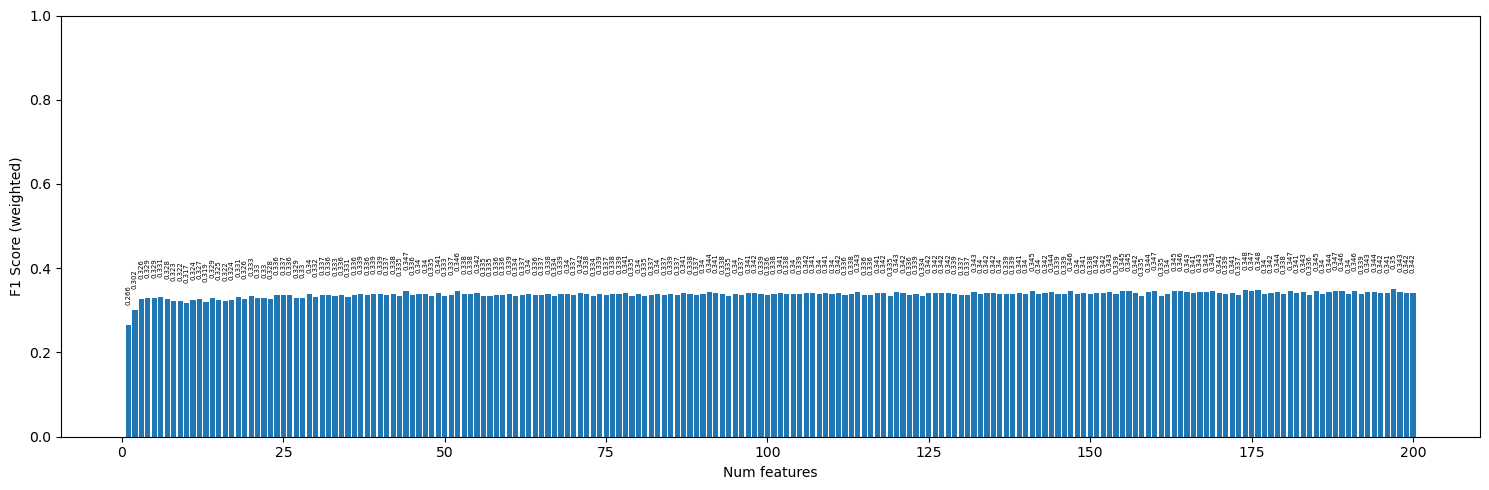

Top 5 scores report
Score: 0.35, No. of Features: 197
Score: 0.348, No. of Features: 174
Score: 0.347, No. of Features: 44
Score: 0.346, No. of Features: 52
Score: 0.345, No. of Features: 141


In [63]:
# does not work with chi2
kbest_logr_anova = SelectKBestRunner(fh.preprocessor, split_data, logr, score_func)
kbest_logr_anova.show_graph()
kbest_logr_anova.show_report()

##### Random Forest

Random Forest was the main choice since the beginning of the investigation since it always performed decently well with a very low feature count. It is not the most consistent but its lightweight nature (in terms of features) cannot be ignored.

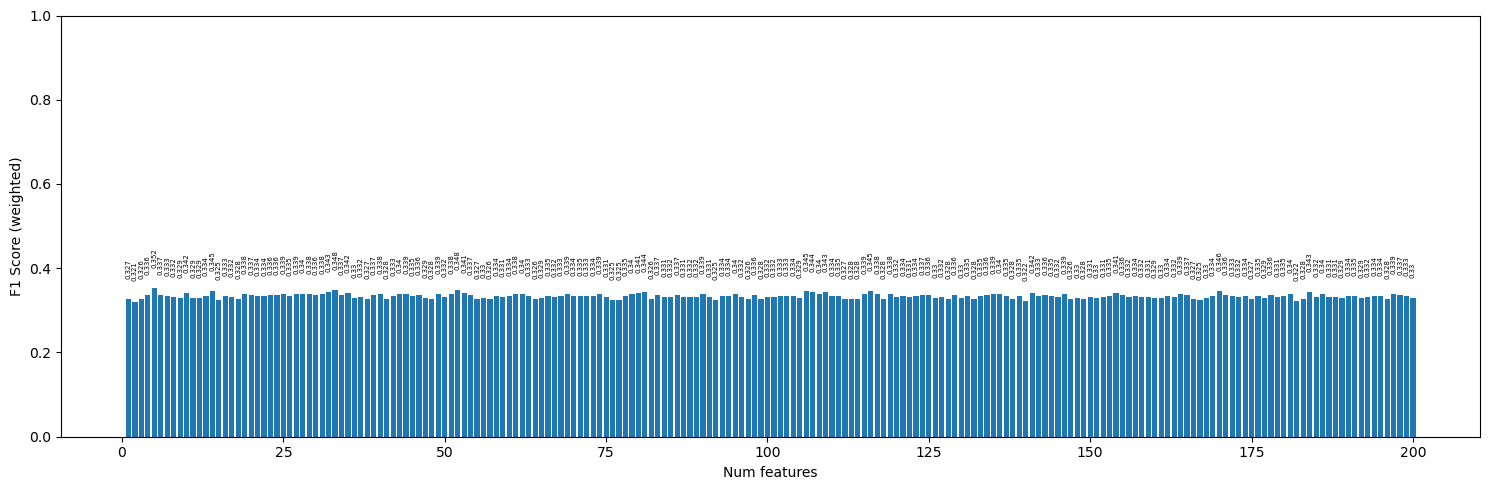

Top 5 scores report
Score: 0.352, No. of Features: 5
Score: 0.348, No. of Features: 33
Score: 0.346, No. of Features: 170
Score: 0.345, No. of Features: 14
Score: 0.344, No. of Features: 81


In [64]:
kbest_rfc_anova = SelectKBestRunner(fh.preprocessor, split_data, rfc, score_func)
kbest_rfc_anova.show_graph()
kbest_rfc_anova.show_report()

##### XGBoost

In terms of performance, XGBoost takes the cake. It trains and predicts extremely fast compared to the others. It maintains high scores but it can be a little inconsistent at times.

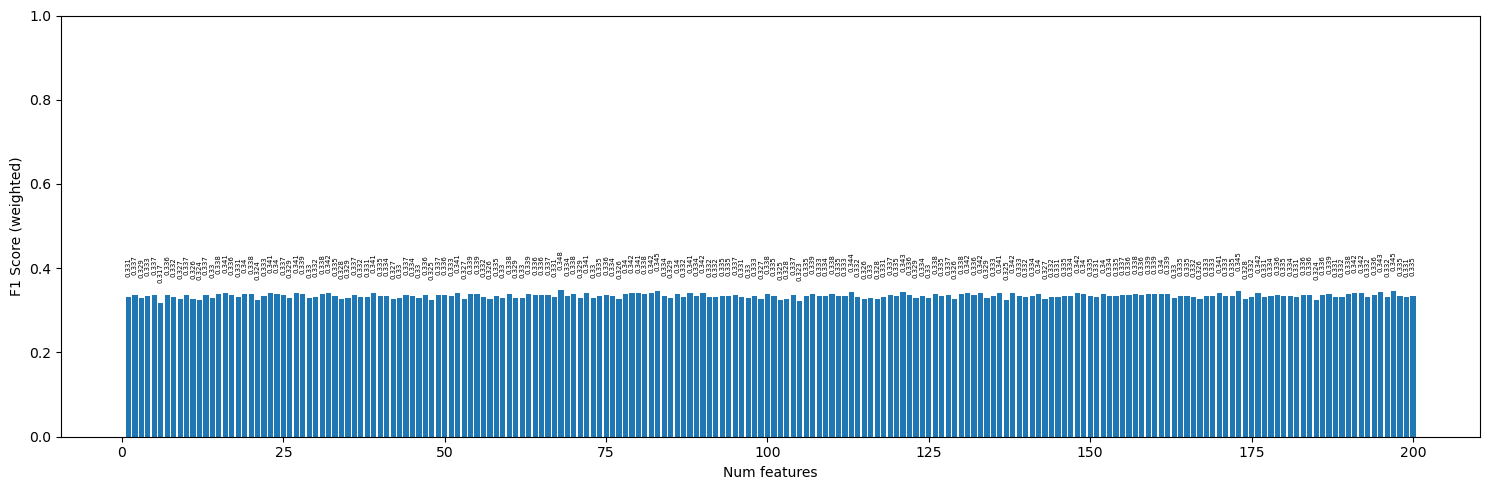

Top 5 scores report
Score: 0.348, No. of Features: 68
Score: 0.345, No. of Features: 83
Score: 0.344, No. of Features: 113
Score: 0.343, No. of Features: 121
Score: 0.342, No. of Features: 32


In [65]:
kbest_xgb_anova = SelectKBestRunner(fh.preprocessor, split_data, xgb, score_func)
kbest_xgb_anova.show_graph()
kbest_xgb_anova.show_report()

#### Recursive Feature Elimination

Takes forever on full dataset. It was already running for 11 hours when it was stoppped. Maybe another time...

In [66]:
# from sklearn.feature_selection import RFE

# f1_score_list_rfe = []

# feature_count = 1 # only to get it started
# k = 1
# while(k <= feature_count):
#     pl_rfe = PipelineTargetTransformerWrapper(
#         make_pipeline(fh.preprocessor, RFE(estimator=rfc, n_features_to_select=k, step=1))
#     )
#     pl_rfe.fit(X_train, y_train)
#     pl_rfe_pred = pl_rfe.predict(X_test)
#     pl_rfe_f1_score = round(f1_score(y_test, pl_rfe_pred, average='weighted'), 3)
#     f1_score_list_rfe.append(pl_rfe_f1_score)

#     feature_count = len(pl_rfe.pipeline[0].get_feature_names_out())
#     k += 1

In [67]:
# graph_feature_selection_supervised(f1_score_list_rfe, feature_count)

In [68]:
# pl_rfe = make_pipeline(fh.preprocessor, RFE(estimator=rfc, n_features_to_select=6, step=10))
# pl_rfe.fit(X_train, y_train)

# selected_feature_mask = pl_rfe[1].get_support()
# selected_features = pl_rfe[0].get_feature_names_out()[selected_feature_mask]
# print(selected_features)
# fh.group_transformed_features(selected_features)

### Model Inspection/Evaluation

#### GridSearchCV

This section uses best features related to our type of dataset and tries them forcefully on the models. KBest scores were chosen from the data in the SelectKBest section.

In [69]:
from sklearn.model_selection import GridSearchCV

###### Logistic Regression

In [127]:
logr2 = LogisticRegression(random_state=42, n_jobs=-1)
plwr_gsearch_logr = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, SelectKBest(score_func), logr2)
)
param_grid_logr = {
    'pipeline__selectkbest__k': [197],  # always chose 197
    'pipeline__logisticregression__solver': ['newton-cg', 'saga'],
    'pipeline__logisticregression__C': [1.0],  # narrowed to this value. it always chose it
    'pipeline__logisticregression__max_iter': [1000],
    'pipeline__logisticregression__tol': [1e-4, 1e-5],
}

gsearch_logr = GridSearchCV(plwr_gsearch_logr, param_grid_logr, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
gsearch_logr.fit(X_train, y_train)

print("Best parameters:", gsearch_logr.best_params_)
print("Best CV score:", gsearch_logr.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'pipeline__logisticregression__C': 1.0, 'pipeline__logisticregression__max_iter': 1000, 'pipeline__logisticregression__solver': 'newton-cg', 'pipeline__logisticregression__tol': 1e-05, 'pipeline__selectkbest__k': 197}
Best CV score: 0.33925


In [128]:
plwr_best_logr = gsearch_logr.best_estimator_
plwr_best_logr_pred = plwr_best_logr.predict(X_test)
print(plwr_best_logr.score(X_test, y_test))
print(classification_report(y_test, plwr_best_logr_pred))

34.5875
              precision    recall  f1-score   support

        DDoS       0.35      0.35      0.35      2686
   Intrusion       0.35      0.31      0.33      2653
     Malware       0.34      0.38      0.36      2661

    accuracy                           0.35      8000
   macro avg       0.35      0.35      0.35      8000
weighted avg       0.35      0.35      0.35      8000



In [129]:
# splits data on its own using K-fold by default; 5-fold
cross_val_score(plwr_best_logr, fh.X, fh.y, scoring='accuracy')

array([0.333375, 0.330875, 0.33575 , 0.33625 , 0.33675 ])

###### Random Forest

In [107]:
plwr_gsearch_rfc = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, SelectKBest(score_func), rfc)
)
param_grid_rfc = {
    'pipeline__selectkbest__k': [33, 81, 170],
    'pipeline__randomforestclassifier__n_estimators': [100, 200],  # tree number
    'pipeline__randomforestclassifier__max_depth': [10, 15, 20],
    'pipeline__randomforestclassifier__min_samples_split': [2],
    'pipeline__randomforestclassifier__min_samples_leaf': [3, 4],
    'pipeline__randomforestclassifier__max_features': ['sqrt'],   # number of features to consider at each split.
}

gsearch_rfc = GridSearchCV(plwr_gsearch_rfc, param_grid_rfc, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
gsearch_rfc.fit(X_train, y_train)

print("Best parameters:", gsearch_rfc.best_params_)
print("Best CV score:", gsearch_rfc.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'pipeline__randomforestclassifier__max_depth': 15, 'pipeline__randomforestclassifier__max_features': 'sqrt', 'pipeline__randomforestclassifier__min_samples_leaf': 3, 'pipeline__randomforestclassifier__min_samples_split': 2, 'pipeline__randomforestclassifier__n_estimators': 200, 'pipeline__selectkbest__k': 81}
Best CV score: 0.34190624999999997


In [108]:
plwr_best_rfc = gsearch_rfc.best_estimator_
plwr_best_rfc_pred = plwr_best_rfc.predict(X_test)
print(plwr_best_rfc.score(X_test, y_test))
print(classification_report(y_test, plwr_best_rfc_pred))

33.8125
              precision    recall  f1-score   support

        DDoS       0.34      0.38      0.36      2686
   Intrusion       0.33      0.28      0.30      2653
     Malware       0.34      0.36      0.35      2661

    accuracy                           0.34      8000
   macro avg       0.34      0.34      0.34      8000
weighted avg       0.34      0.34      0.34      8000



In [109]:
# splits data on its own using K-fold by default; 5-fold
cross_val_score(plwr_best_rfc, fh.X, fh.y, scoring='accuracy')

array([0.3375  , 0.329125, 0.328375, 0.3285  , 0.33225 ])

###### XGBoost

In [124]:
plwr_gsearch_xgb = PipelineTargetTransformerWrapper(
    make_pipeline(fh.preprocessor, SelectKBest(score_func), xgb)
)
param_grid_xgb = {
    'pipeline__selectkbest__k': [68, 83, 113],
    'pipeline__xgbclassifier__n_estimators': [100, 200],
    'pipeline__xgbclassifier__max_depth': [3, 5, 10],             # max tree depth for base learners
    'pipeline__xgbclassifier__learning_rate': [0.1],    # to prevent overfitting
    'pipeline__xgbclassifier__subsample': [0.8],
    'pipeline__xgbclassifier__colsample_bytree': [0.8],
    'pipeline__xgbclassifier__gamma': [0, 0.1]                # min loss reduction required to make a further partition
}

gsearch_xgb = GridSearchCV(plwr_gsearch_xgb, param_grid_xgb, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
gsearch_xgb.fit(X_train, y_train)

print("Best parameters:", gsearch_xgb.best_params_)
print("Best CV score:", gsearch_xgb.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'pipeline__selectkbest__k': 68, 'pipeline__xgbclassifier__colsample_bytree': 0.8, 'pipeline__xgbclassifier__gamma': 0, 'pipeline__xgbclassifier__learning_rate': 0.1, 'pipeline__xgbclassifier__max_depth': 3, 'pipeline__xgbclassifier__n_estimators': 100, 'pipeline__xgbclassifier__subsample': 0.8}
Best CV score: 0.34028125


In [125]:
plwr_best_xgb = gsearch_xgb.best_estimator_
plwr_best_xgb_pred = plwr_best_xgb.predict(X_test)
print(plwr_best_xgb.score(X_test, y_test))
print(classification_report(y_test, plwr_best_xgb_pred))

33.625
              precision    recall  f1-score   support

        DDoS       0.34      0.37      0.35      2686
   Intrusion       0.33      0.26      0.29      2653
     Malware       0.34      0.38      0.36      2661

    accuracy                           0.34      8000
   macro avg       0.34      0.34      0.33      8000
weighted avg       0.34      0.34      0.33      8000



In [126]:
# splits data on its own using K-fold by default; 5-fold
cross_val_score(plwr_best_xgb, fh.X, fh.y, scoring='accuracy')

array([0.334125, 0.333875, 0.331875, 0.340375, 0.336125])

#### Permutation Importance

"Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set."

Needs one of the classifiers: Random Forest, Gradient Boosting, etc.

- https://stackoverflow.com/questions/62106204/permutation-importance-using-a-pipeline-in-scikit-learn
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html
- https://scikit-learn.org/stable/modules/permutation_importance.html

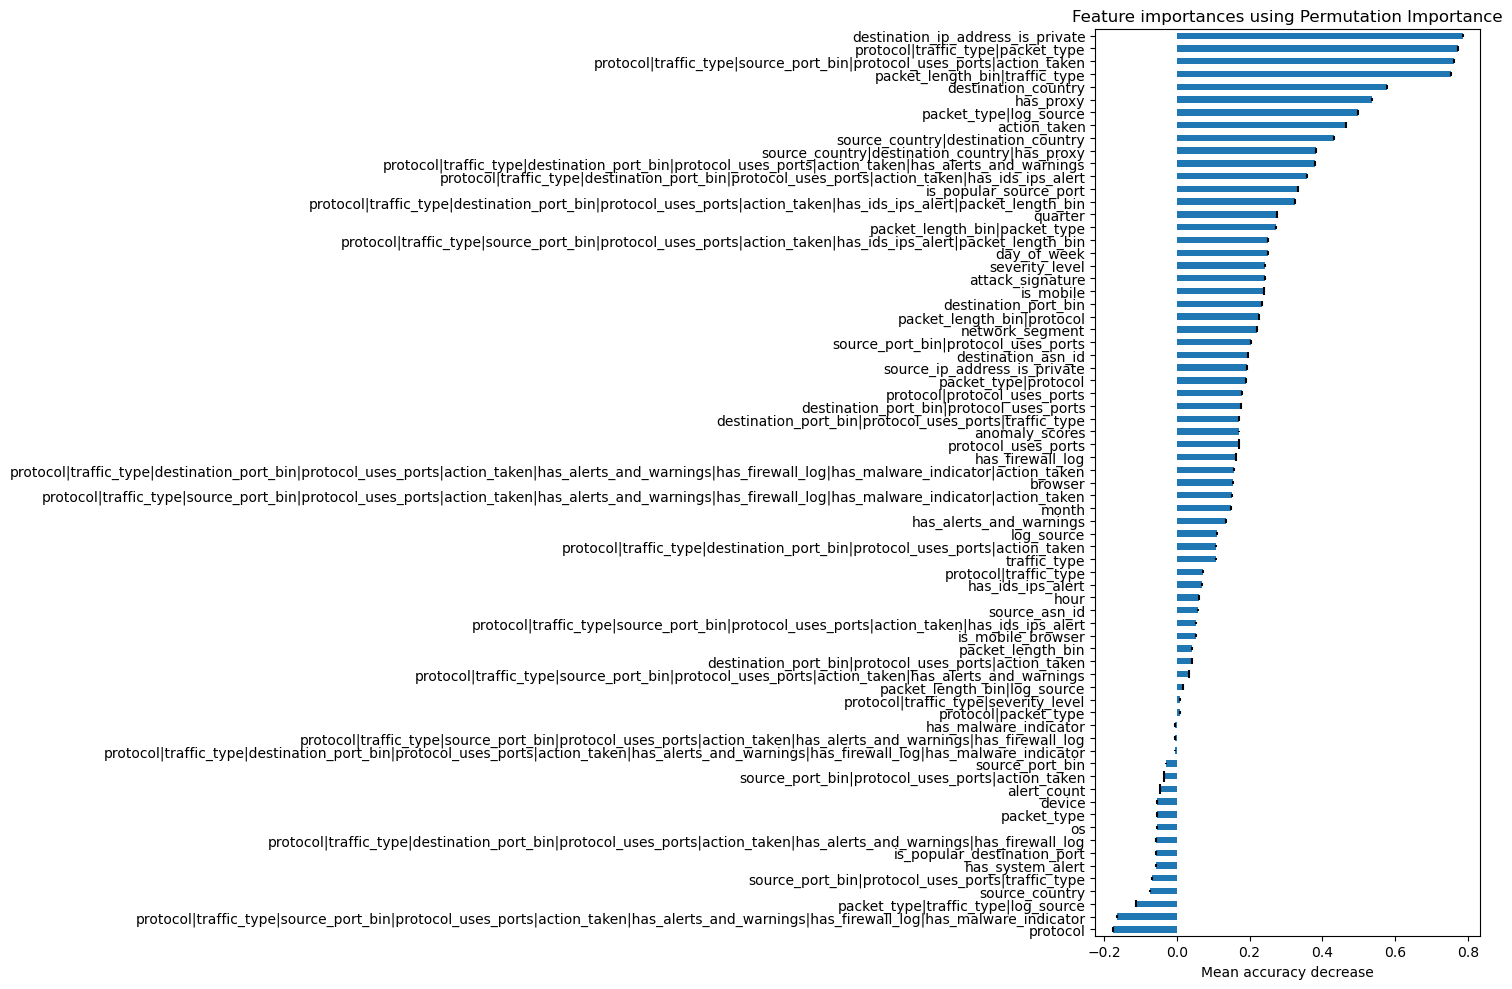

In [130]:
from sklearn.inspection import permutation_importance

perm_importances = permutation_importance(
    plwr_best_logr,
    X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

perm_sorted_idx = perm_importances.importances_mean.argsort()
df_perm_importances = pd.Series(perm_importances.importances_mean, index=fh.X.columns[perm_sorted_idx])

fig, ax = plt.subplots()
df_perm_importances.sort_values().plot.barh(yerr=perm_importances.importances_std, ax=ax, figsize=(15, 10))
ax.set_title("Feature importances using Permutation Importance")
ax.set_xlabel("Mean accuracy decrease")
fig.tight_layout()

## Final Model

### Model Selection

The best performing models were Logistic Regression, Random Forest, and XGBoost. They gave the highest scores throughout. However, the logistic regression model stood out because it consistently gave the highest scores - over cross validation as well. It must be said that it requires a lot of features though.

In [131]:
plwr_final = plwr_best_logr

### Features

The features are taken from the model/estimator.

In [132]:
selected_feature_mask = plwr_final.pipeline['selectkbest'].get_support()
selected_features = plwr_final.pipeline['columntransformer'].get_feature_names_out()[selected_feature_mask]
selected_features_base = fh.group_transformed_features(selected_features)
plwr_final.set_features_data(fh.X[selected_features_base])

### Persistence

Pickle was chosen to store the model since it was compatible with our workflow. ONNX was tested but did not work due to our pipeline wrapper structure.

Dill was chosen as the module to generate the pickle since the default pickle module did not store extra functions or classes, only references. We needed the model to include things like our wrapper function in it for it to work.

In [133]:
import dill

with open("../model/model_pl_wrapper.pckl","wb") as f:
    dill.dump(plwr_final, f)